<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрука-данных" data-toc-modified-id="Загрука-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрука данных</a></span></li><li><span><a href="#Анализ-данных-и-обработка-датафрейма" data-toc-modified-id="Анализ-данных-и-обработка-датафрейма-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных и обработка датафрейма</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Создание-алгоритма-подбора-ближайших-соседей" data-toc-modified-id="Создание-алгоритма-подбора-ближайших-соседей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание алгоритма подбора ближайших соседей</a></span><ul class="toc-item"><li><span><a href="#Подбор-параметров-для-поиска-соседей" data-toc-modified-id="Подбор-параметров-для-поиска-соседей-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подбор параметров для поиска соседей</a></span></li><li><span><a href="#Подбор-обучающих-признаков" data-toc-modified-id="Подбор-обучающих-признаков-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Подбор обучающих признаков</a></span></li></ul></li><li><span><a href="#Проверка-работы-алгоритма-на-валидационных-данных" data-toc-modified-id="Проверка-работы-алгоритма-на-валидационных-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка работы алгоритма на валидационных данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# ***Задача***

Компании по продаже товаров необходимо разработать алгоритм, который для каждого нового товара будет определять пять наиболее схожих по своим признакам товаров из имеющейся базы данных компании. В качестве исходных данных даны следующие файлы:
1. base.csv - база данных имеющихся у компании товаров (содержит Id товара и 72 столбца с признаками);
2. train.csv - таблица с новыми товарами, к которым необходимо найти близкие товары из файла base.csv(содержит Id товара, 72 столбца с признаками и столбец target c Id наиболее близкого товара из файла base.csv, который подобрал эксперт);
3. validation.csv - таблица с новыми товарами, к которым необходимо найти близкие товары из файла base.csv, для оценки работы алгоритма (содержит Id товара и 72 столбца с признаками);
4. validation_answer.csv - таблица, с Id новоых товаров из файла validation.csv и Id наиболее близких товаров из файла base.csv, который подобрал эксперт.

Оценку качества работы алгоритма необходимо производить с помощью метрики *accuracy@5*.

Перед началом выполнения работы установим библиотеку FAISS и выполним загрузку необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import time
import faiss

import catboost as cb
from catboost import CatBoostClassifier
from catboost import cv, Pool

## Загрука данных

Первоначально, прочитаем исходные файлы и запишем их в датафреймы *df_base*, *df_train*, *df_validation_features* и *df_validation_target*.

In [2]:
df_base = pd.read_csv('C:/Users/AAV19/Мастерская2/base.csv', index_col=0)
df_train = pd.read_csv('C:/Users/AAV19/Мастерская2/train.csv', index_col=0)
df_validation_features = pd.read_csv('C:/Users/AAV19/Мастерская2/validation.csv', index_col=0)
df_validation_target = pd.read_csv('C:/Users/AAV19/Мастерская2/validation_answer.csv', index_col=0)

Для оценки результата выведем на экран первые пять строк каждого датафрейма.

In [3]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [4]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [5]:
df_validation_features.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [6]:
df_validation_target.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Чтение файлов и запись данных выполнены успешно.

## Анализ данных и обработка датафрейма

Первоначально проверим размерности датафреймов.

In [7]:
print(df_base.shape, df_train.shape, df_validation_features.shape, df_validation_target.shape)

(2918139, 72) (100000, 73) (100000, 72) (100000, 1)


Количество строк в датафреймах достаточно большое. Выполним проверку наличия пропусков в каждом датафрейме.

In [8]:
df_base.isna().sum().sum()

0

In [9]:
df_train.isna().sum().sum()

0

In [10]:
df_validation_features.isna().sum().sum()

0

In [11]:
df_validation_target.isna().sum()

Expected    0
dtype: int64

Во всех датафреймах нет ни одного пропуска. 

Перед тем как перейти к дальнейшему анализу данных разделим датафрейм *df_train* с тренировочными данными на датафреймы *df_train_targets* и *df_train_features* с обучающими и целевым признаками.

In [12]:
df_train_targets = df_train["Target"]
df_train_features = df_train.drop("Target", axis=1)

Так как количество данных в датафреймах достаточно большое, далее выполним только проверку числовых значений в графическом виде. Для экономии времени, построение гистаграмм будем выполнять не для всех строк датафреймов, а только для выборок в размере 10 тысяч строк. Для этого создадим соответствующие выборки *df_base_sample*, *df_train_sample* и *df_validation_features_sample*.

In [13]:
df_base_sample = df_base.copy().reset_index().loc[1256498:1266498]
df_train_sample = df_train.copy().reset_index().loc[45284:55284]
df_validation_features_sample = df_validation_features.copy().reset_index().loc[45284:55284]

Далее, выполним построение гистограмм для каждого обучающего признака. Для удобства сравнения данных, будем выводить гистограммы для каждого датафрейма в три столбца.

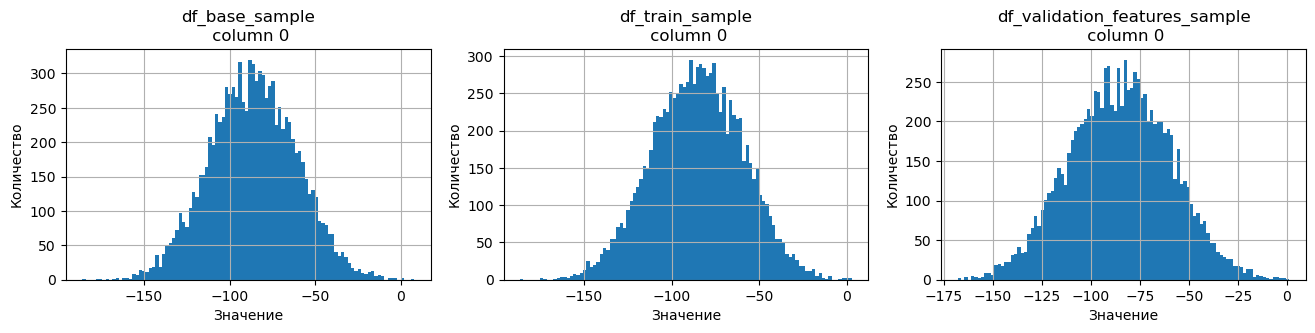

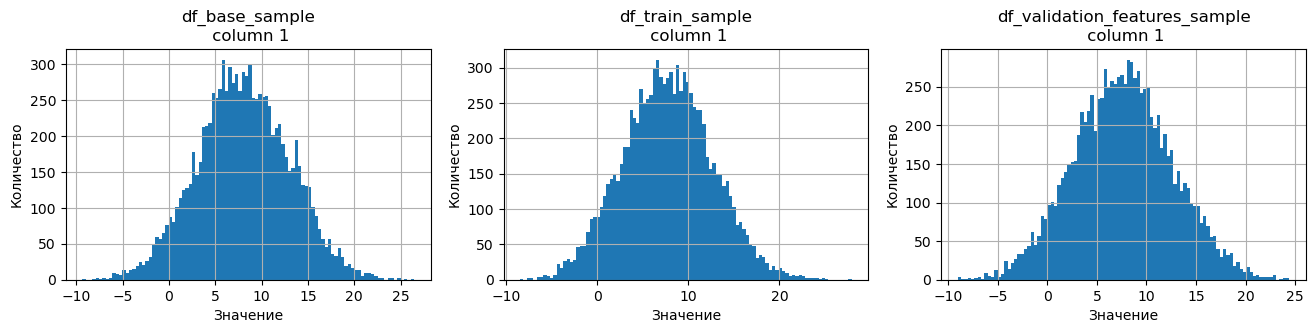

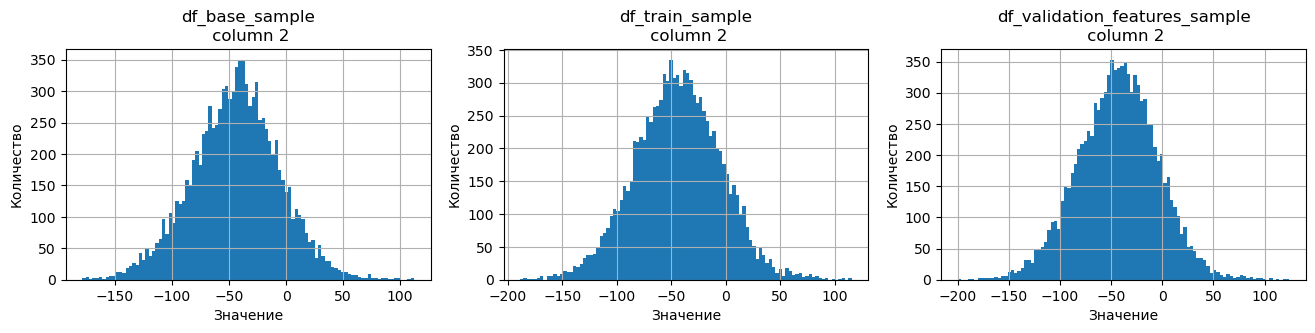

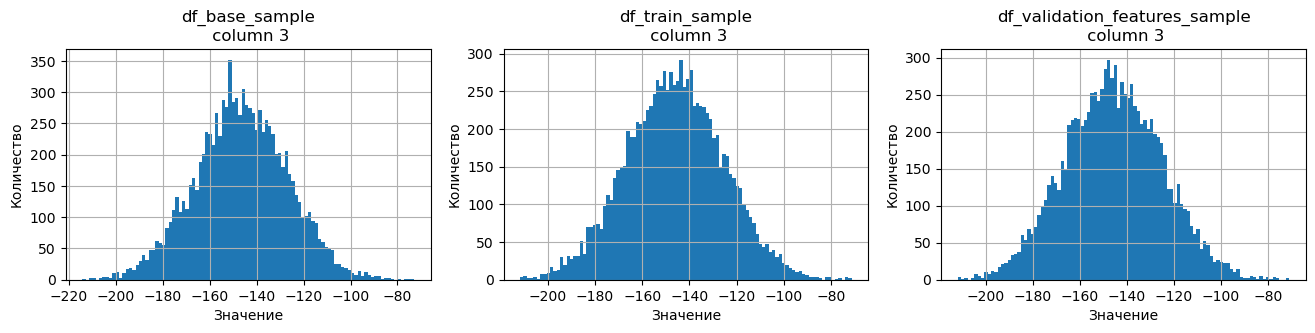

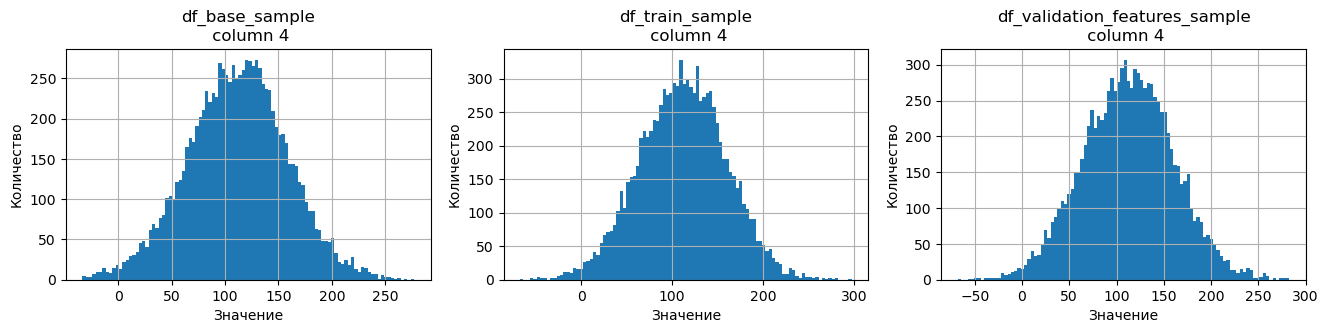

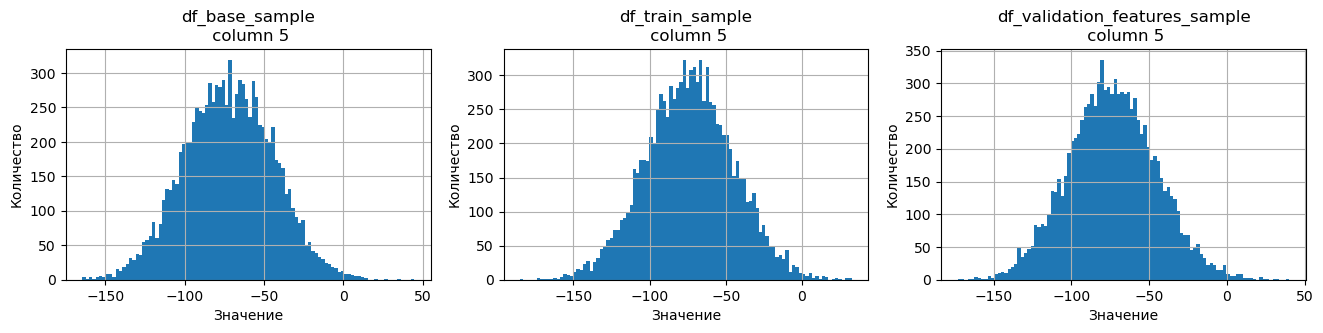

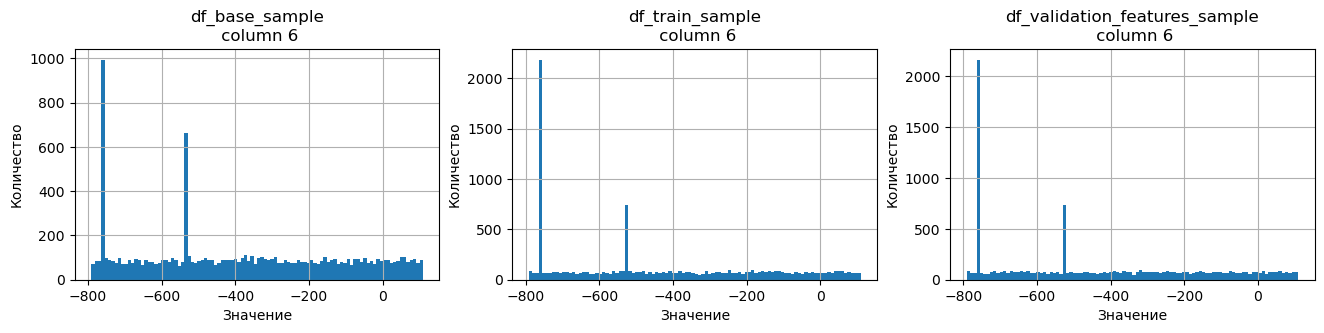

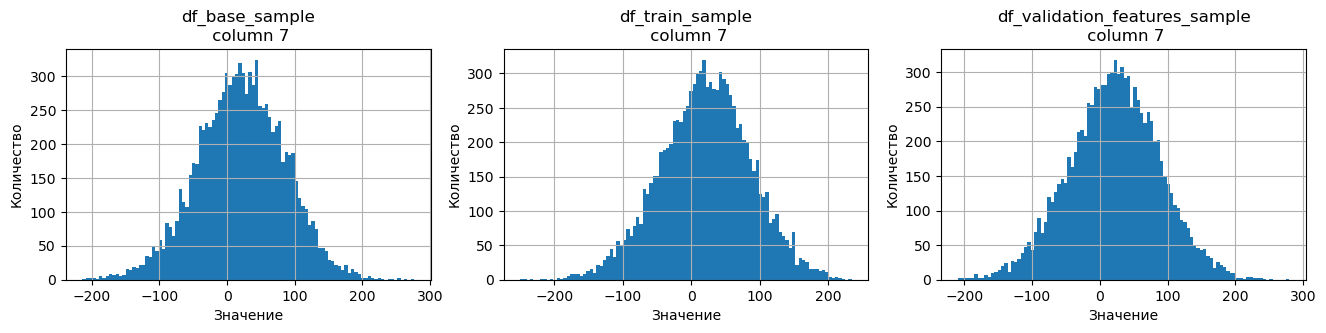

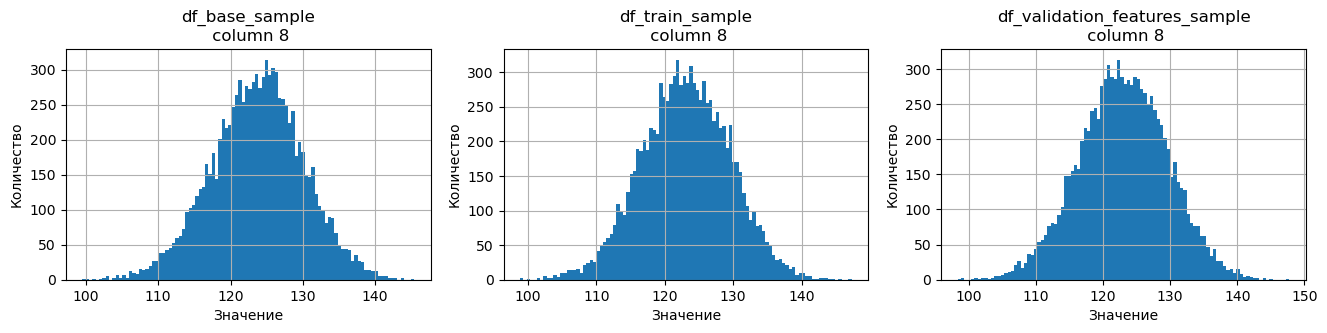

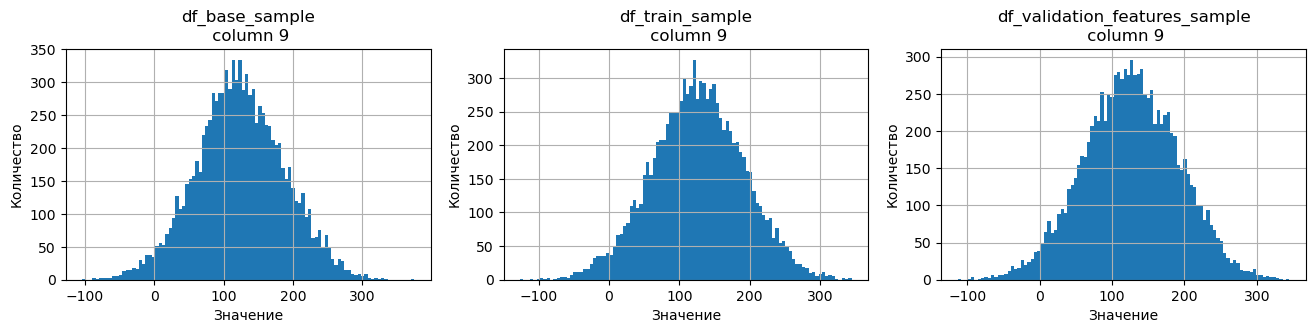

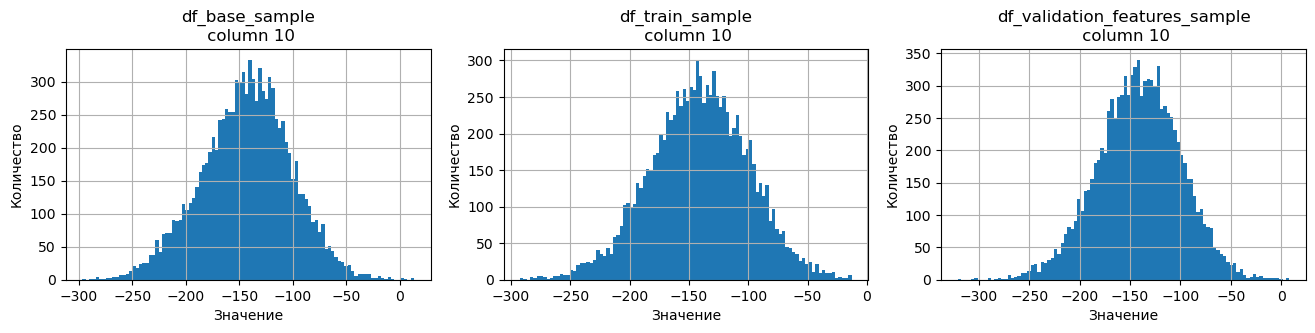

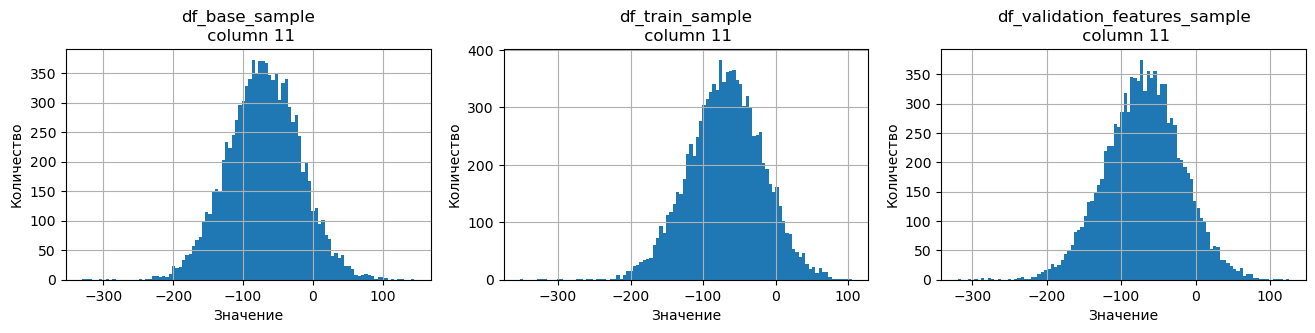

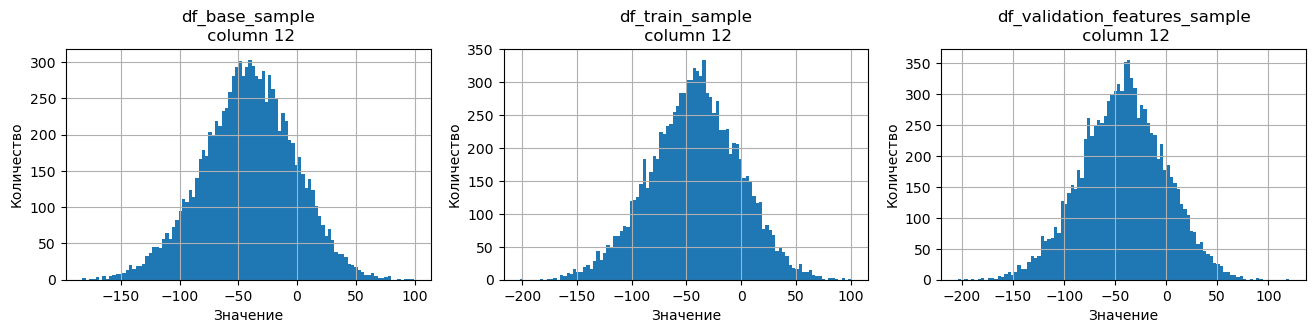

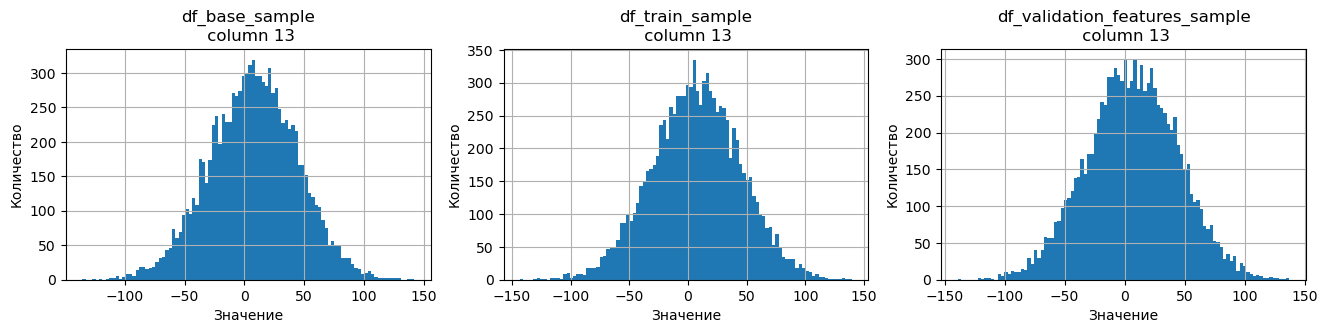

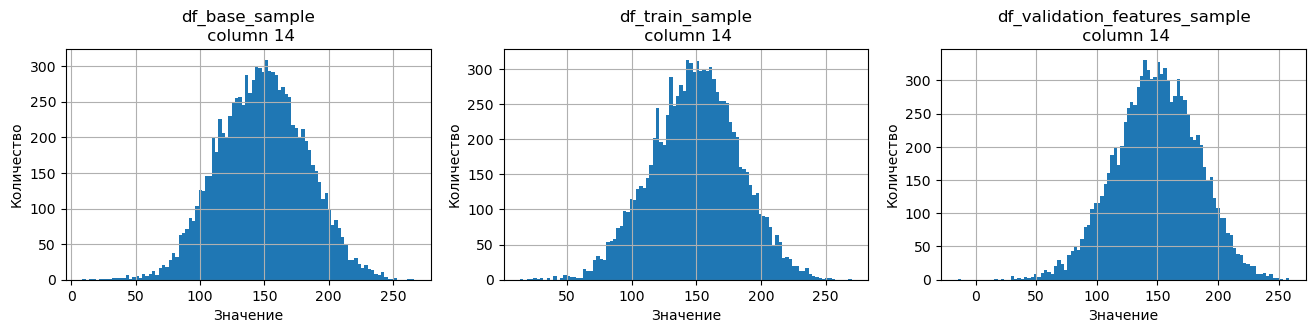

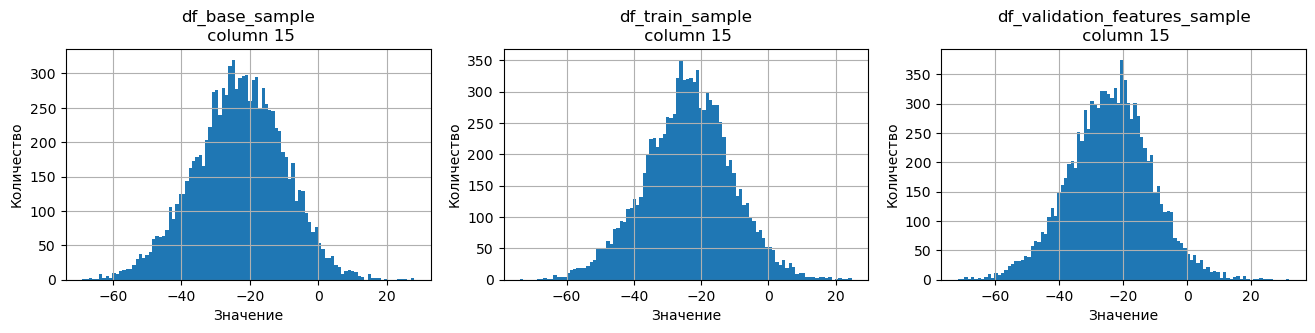

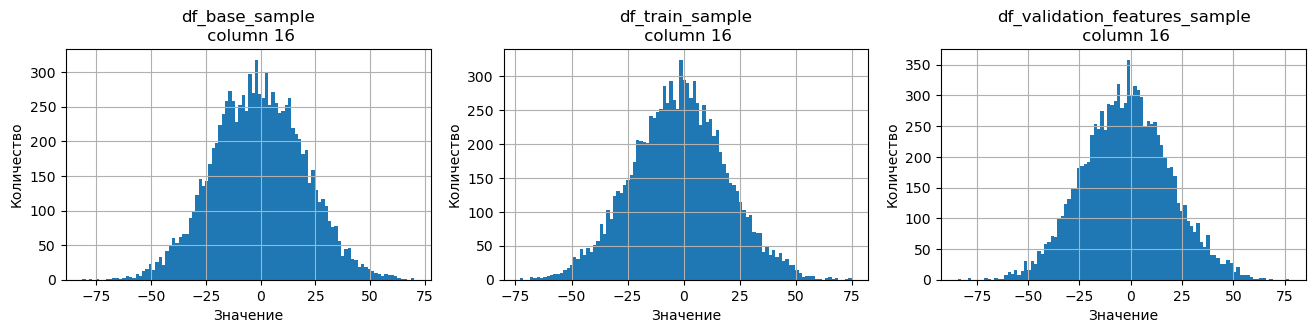

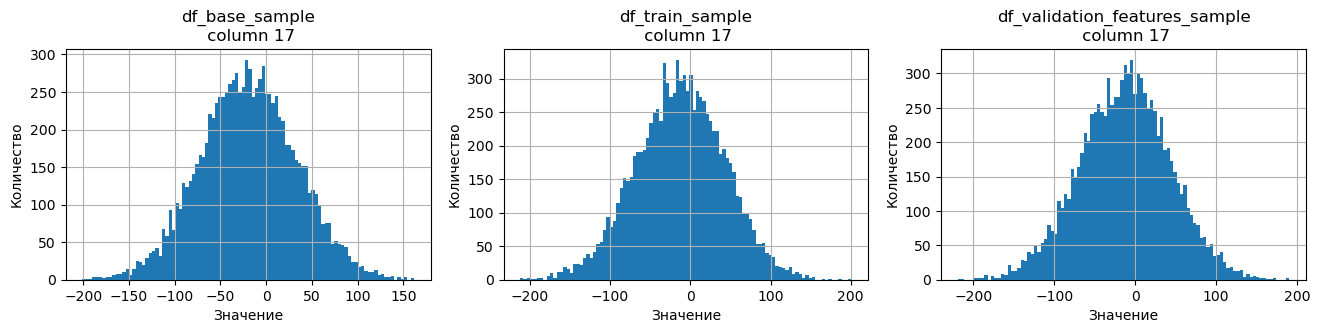

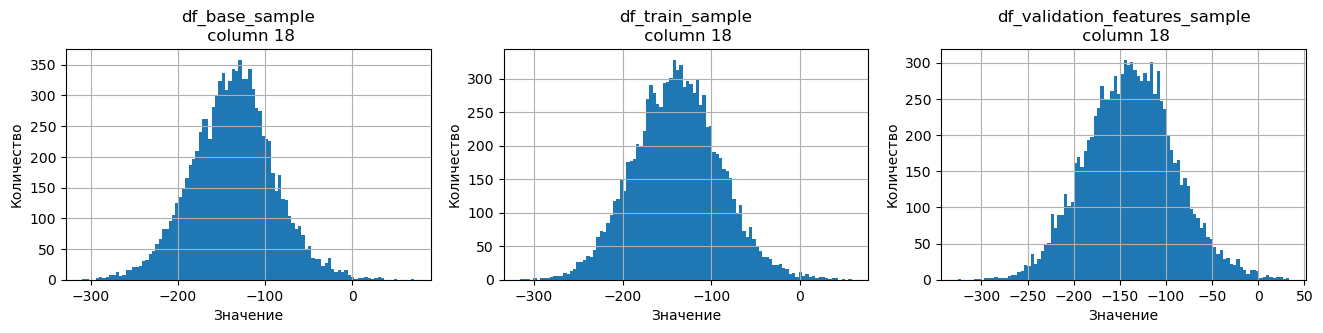

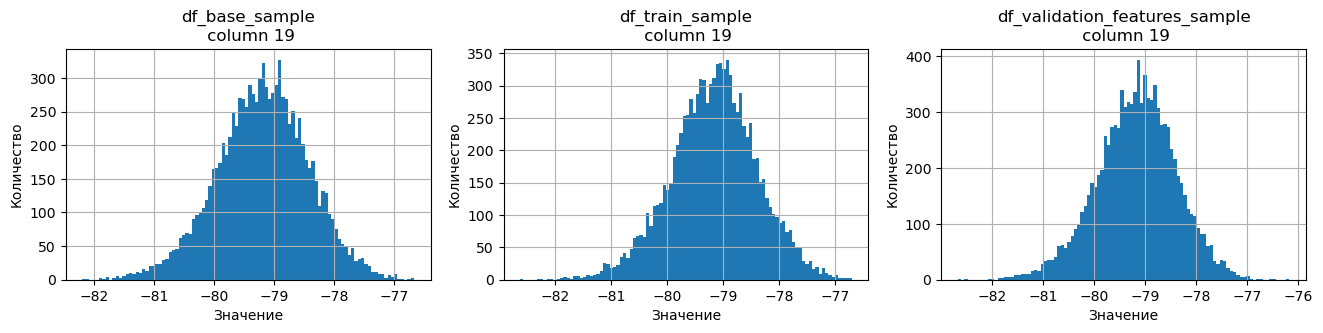

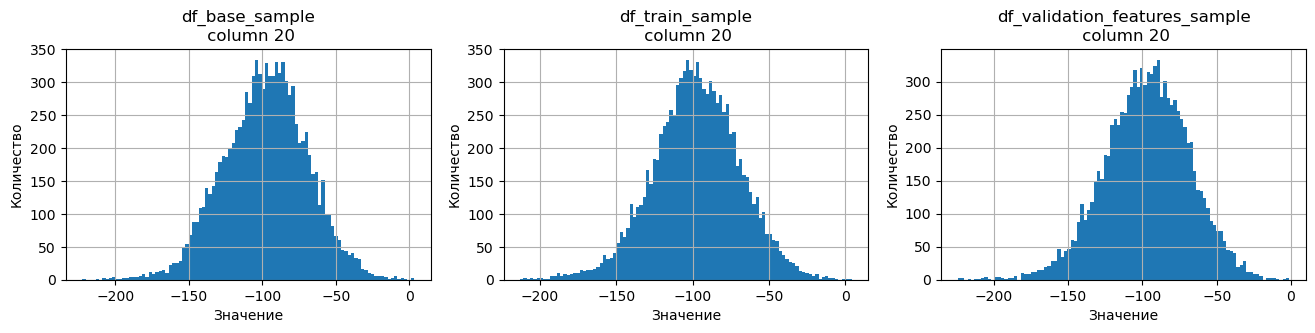

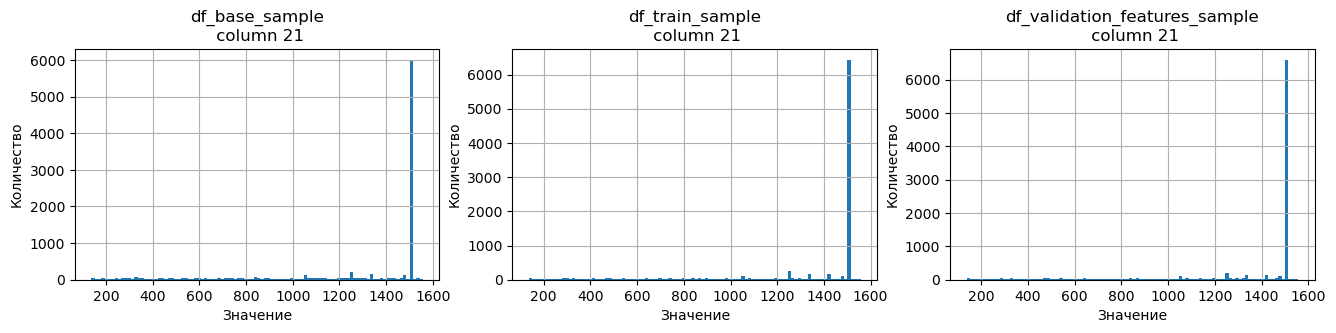

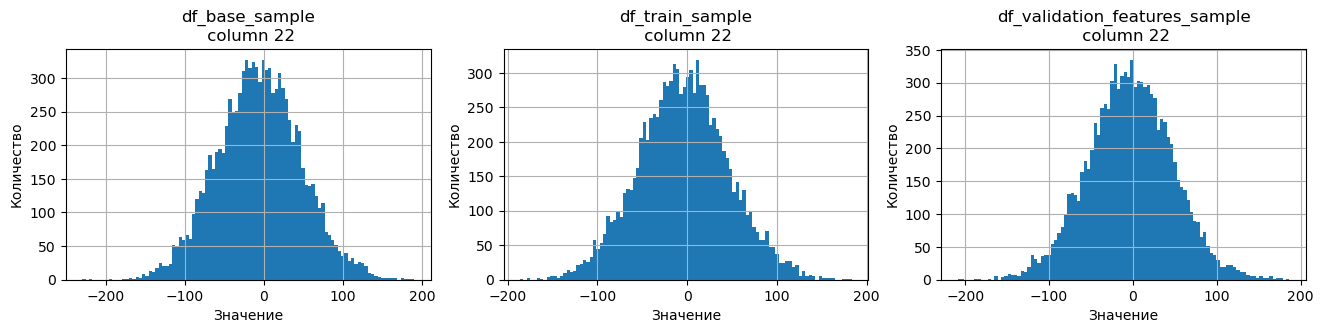

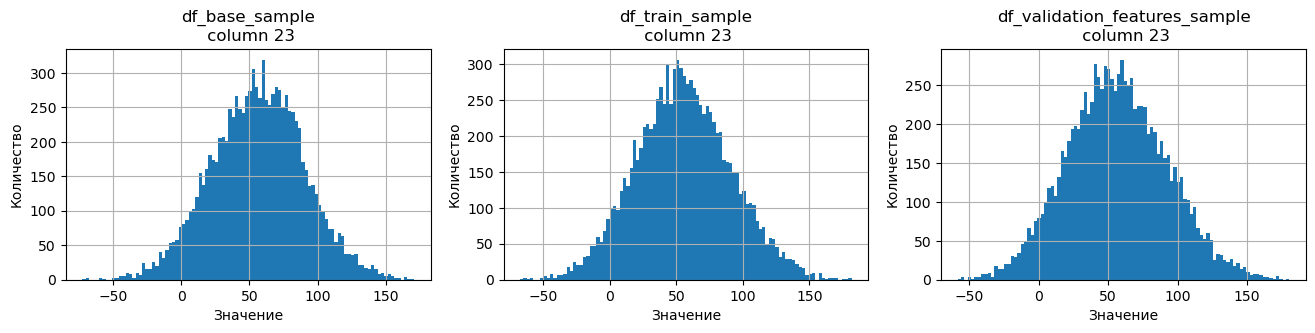

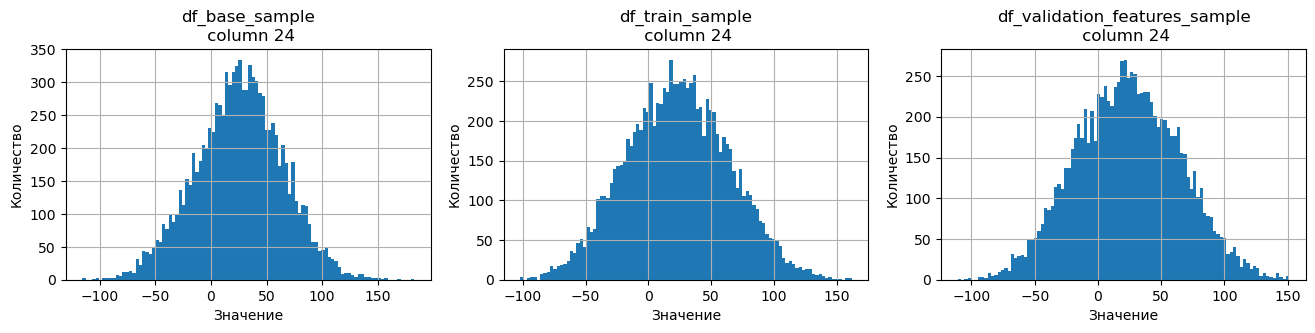

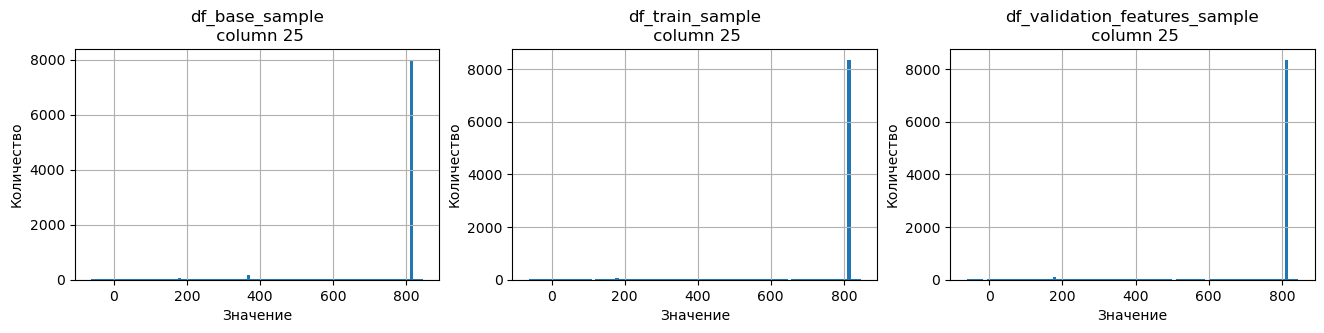

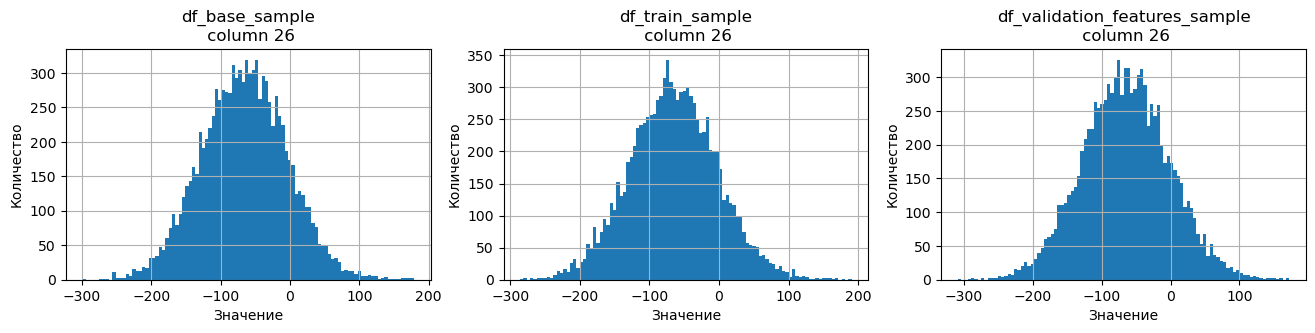

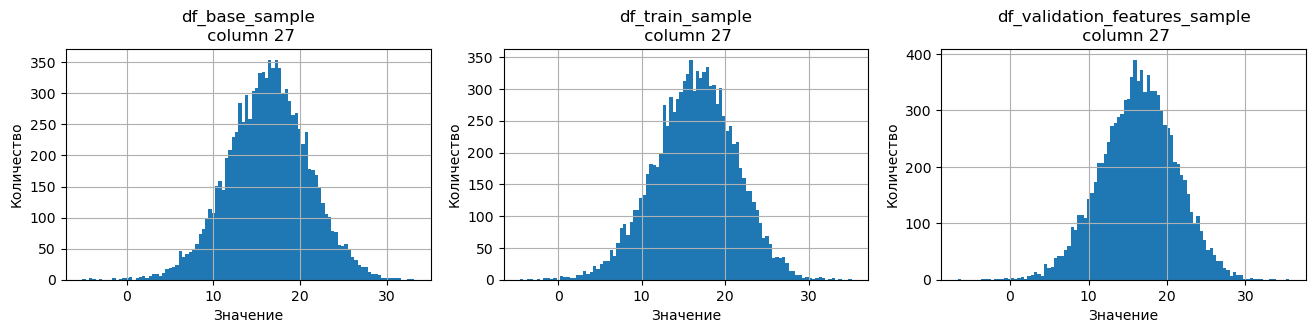

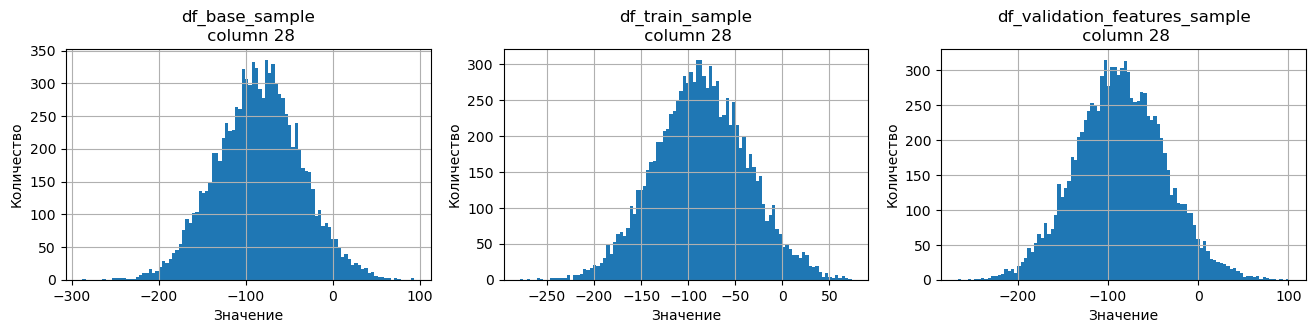

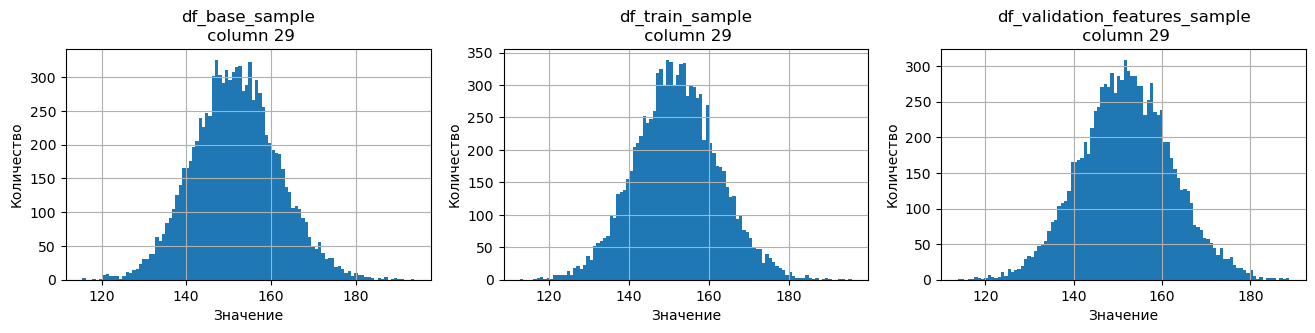

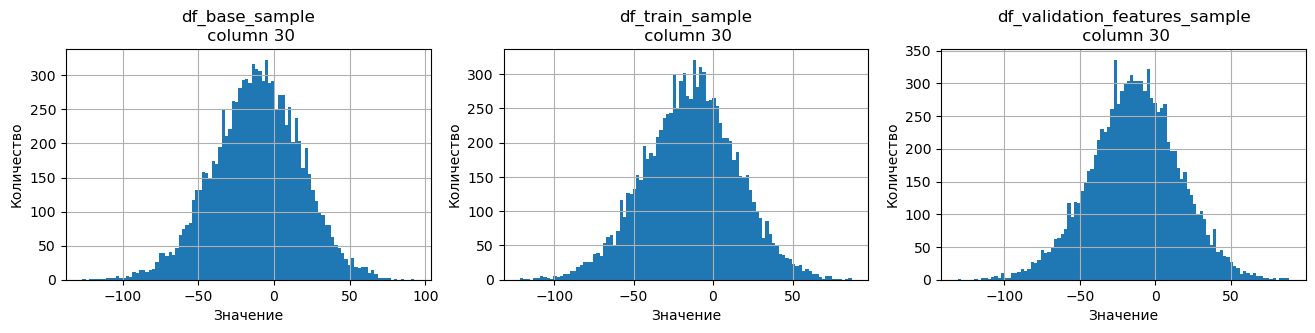

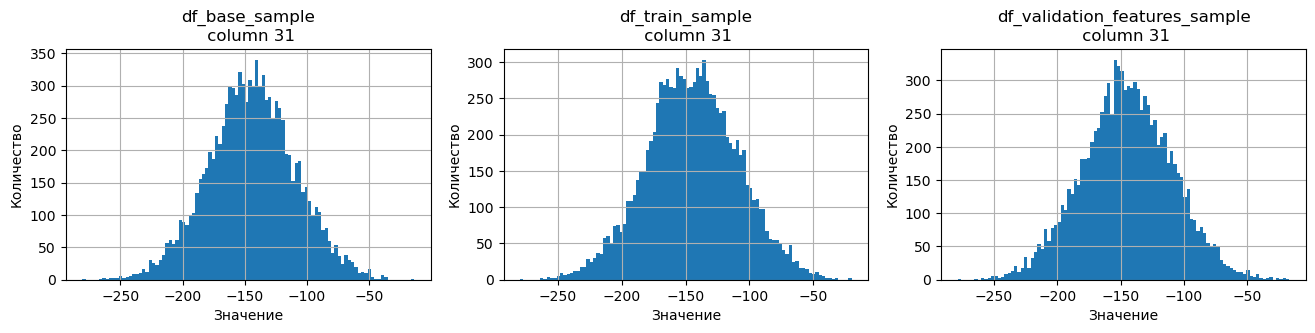

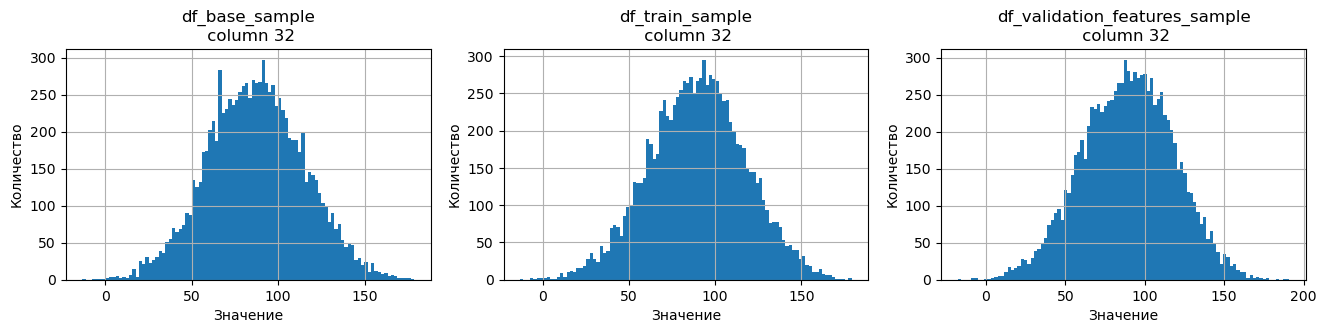

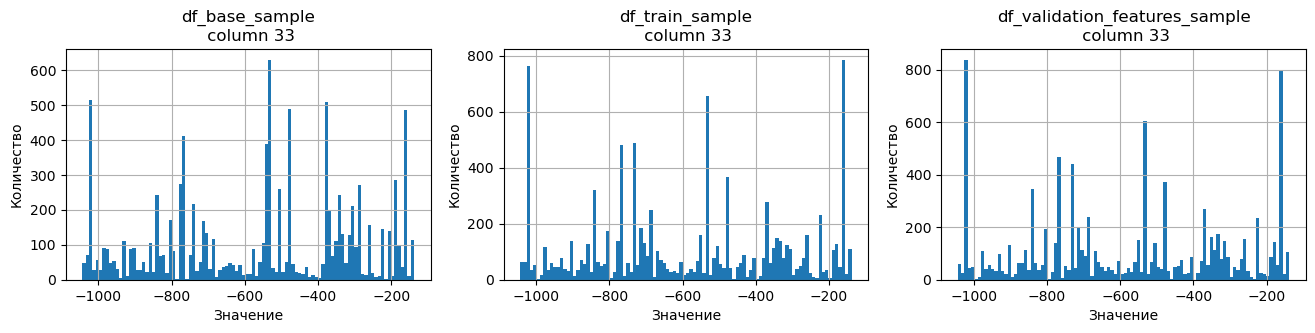

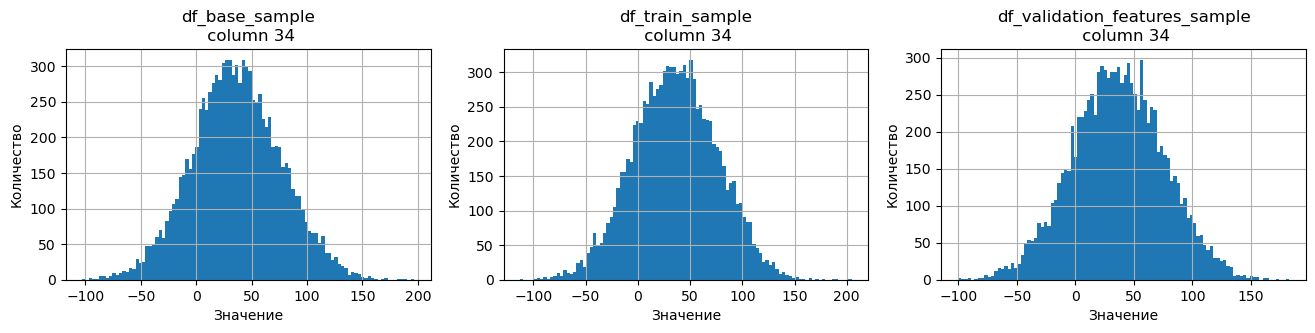

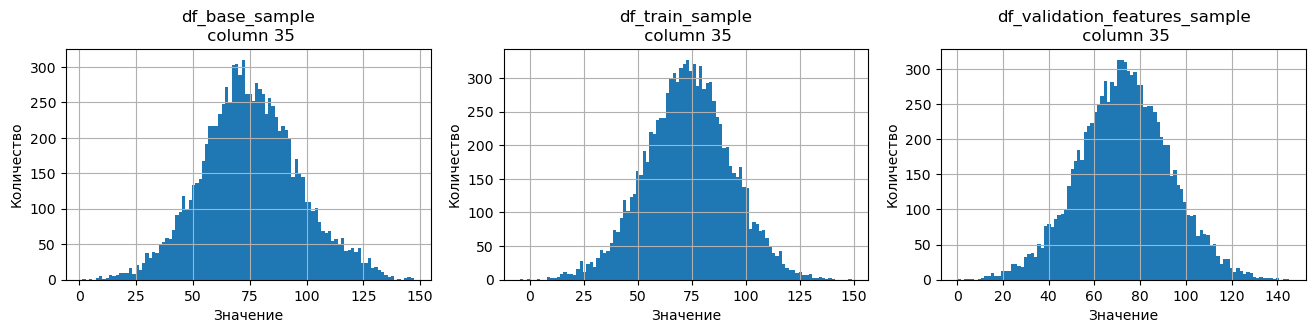

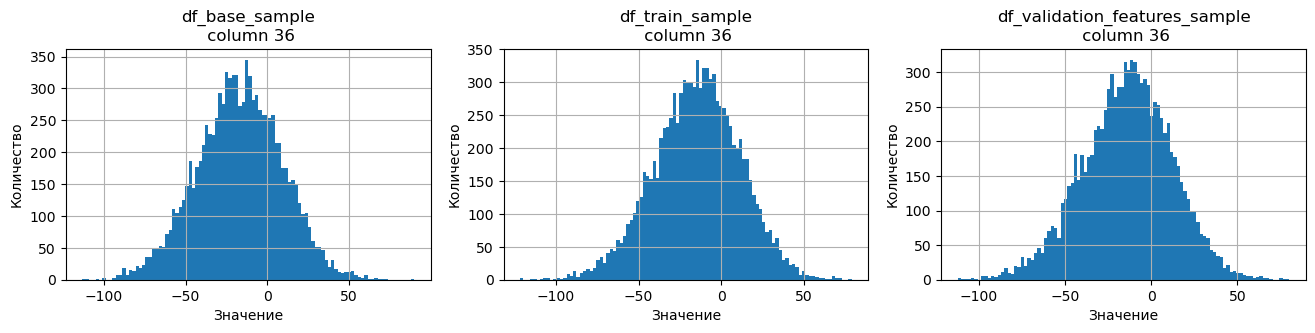

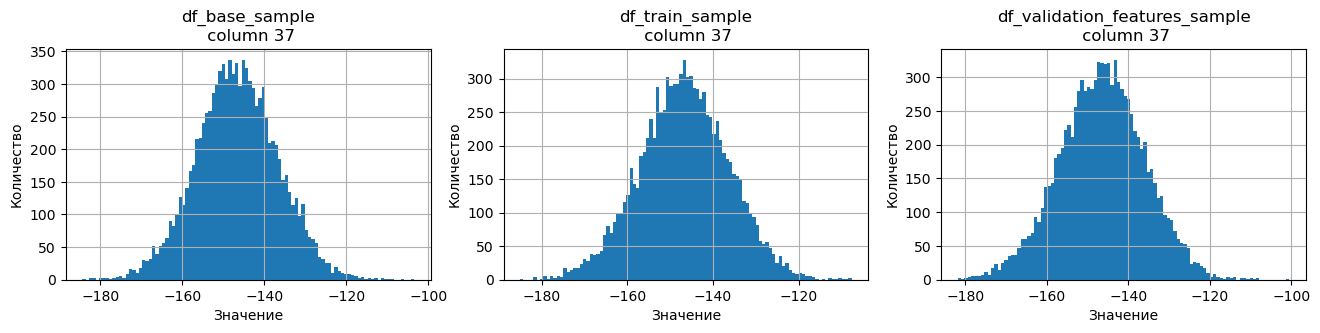

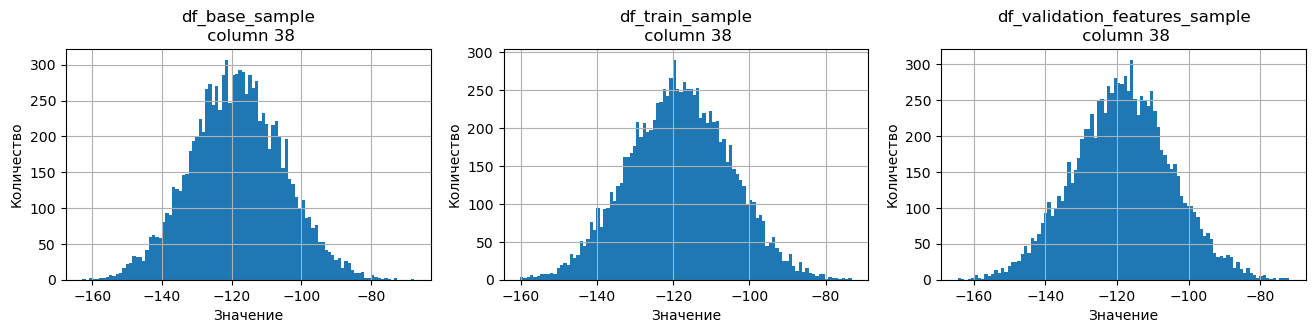

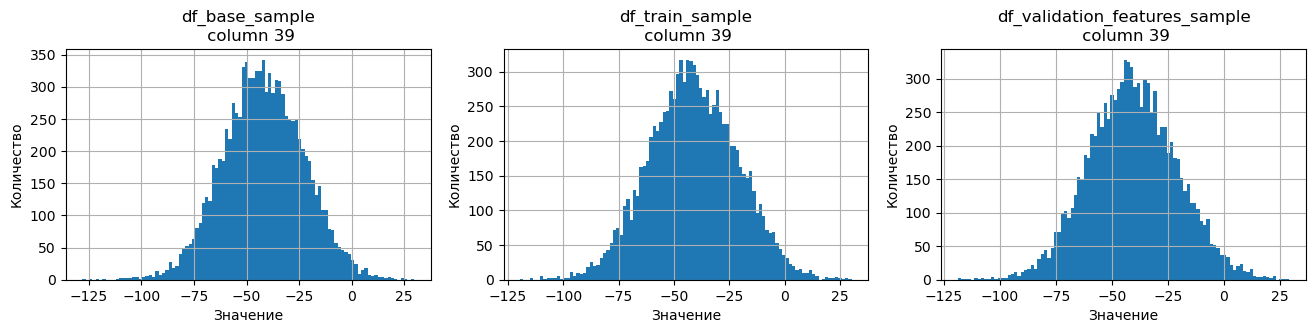

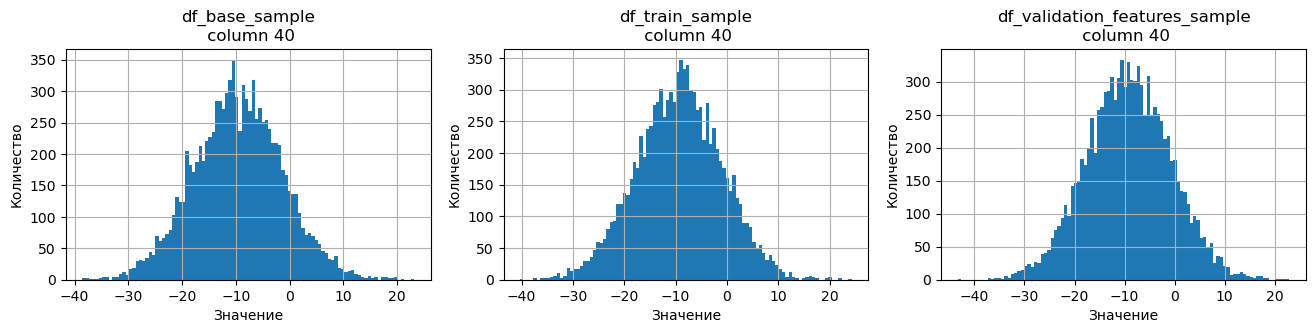

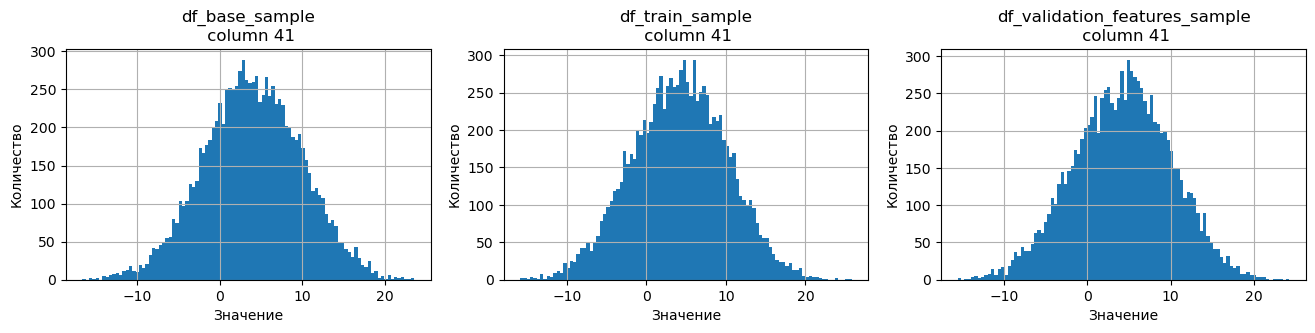

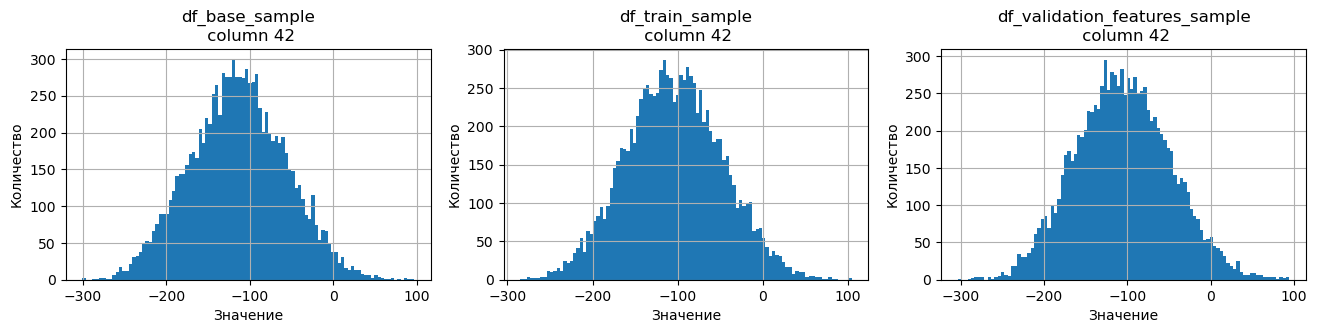

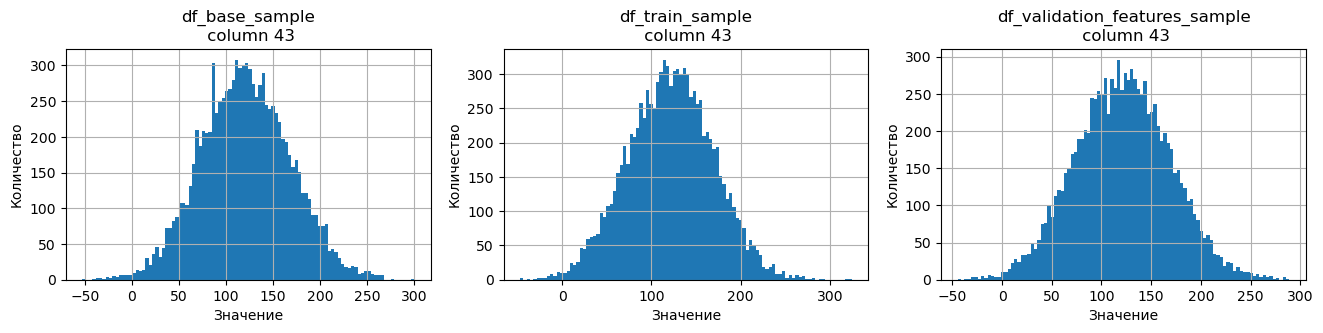

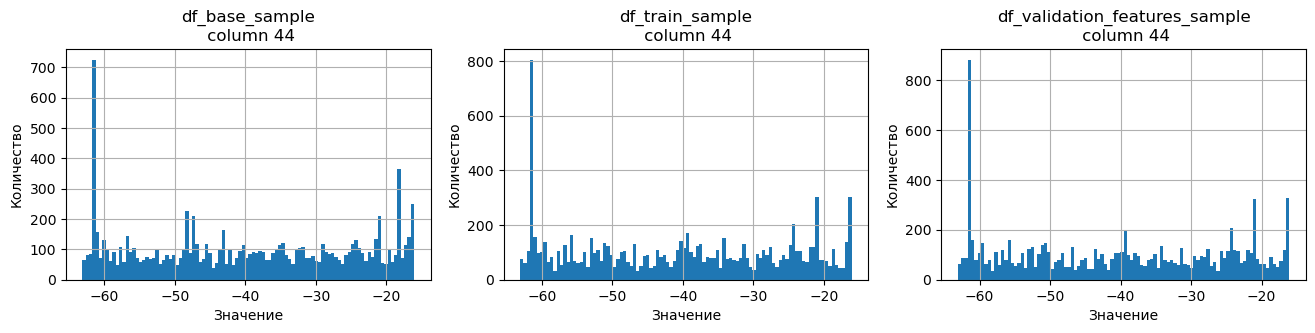

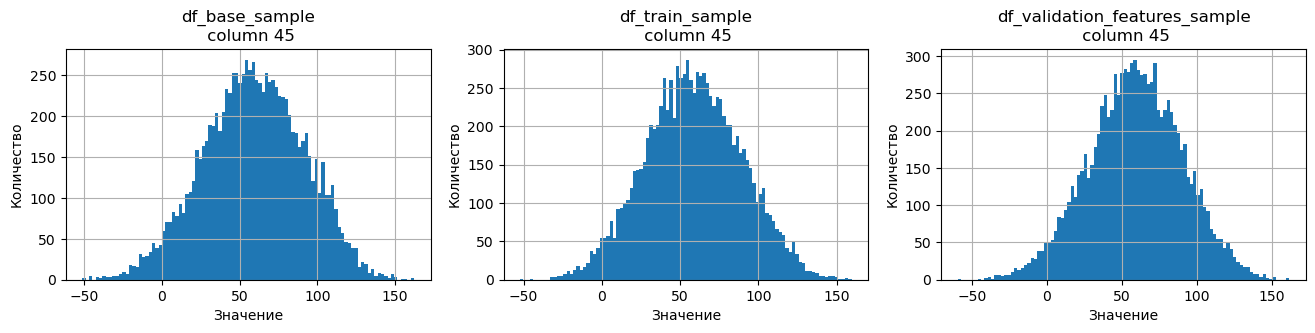

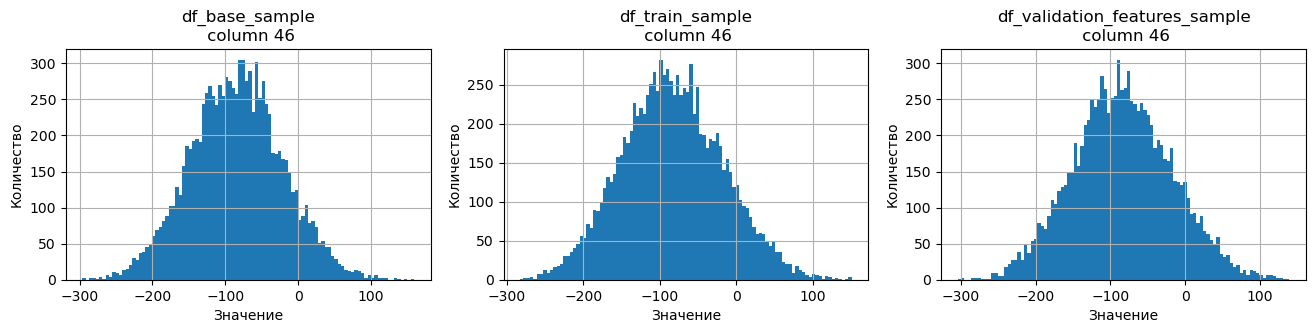

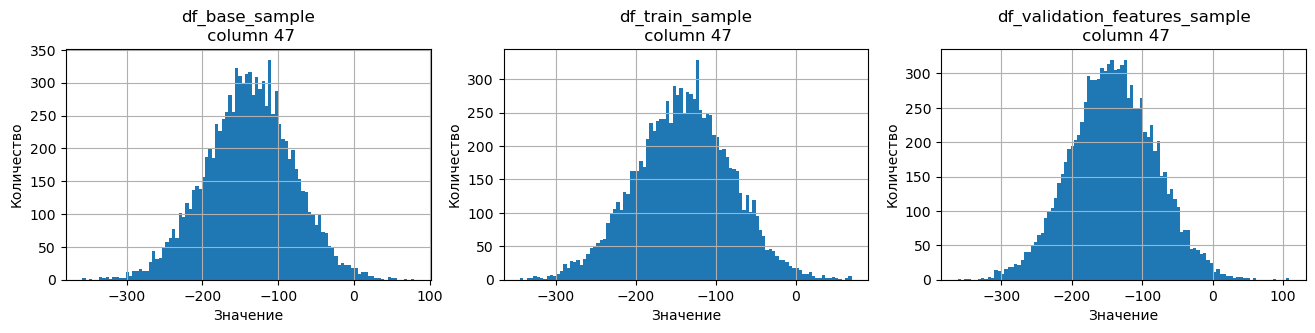

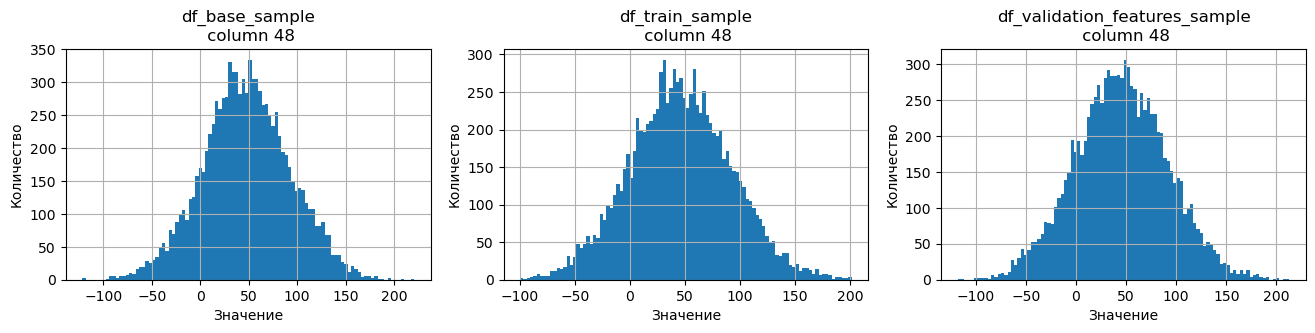

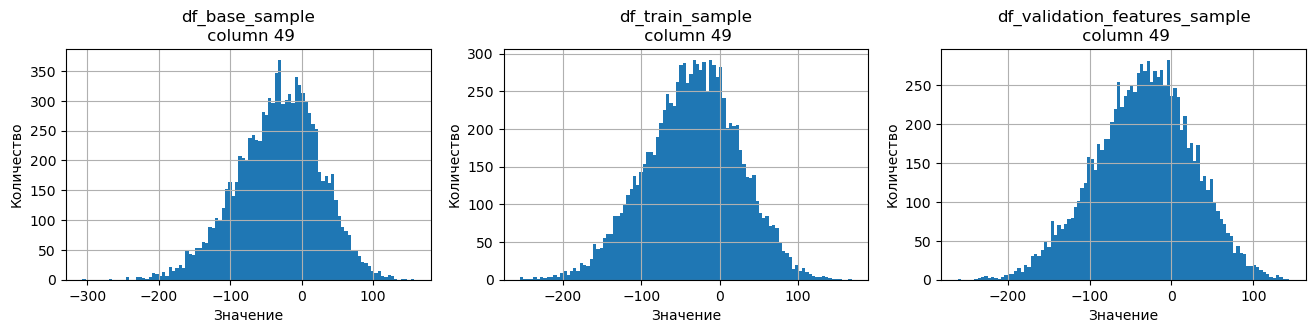

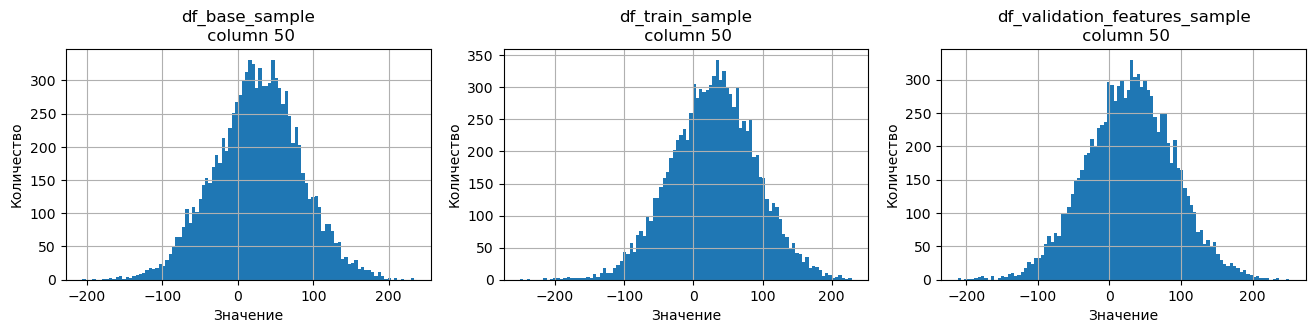

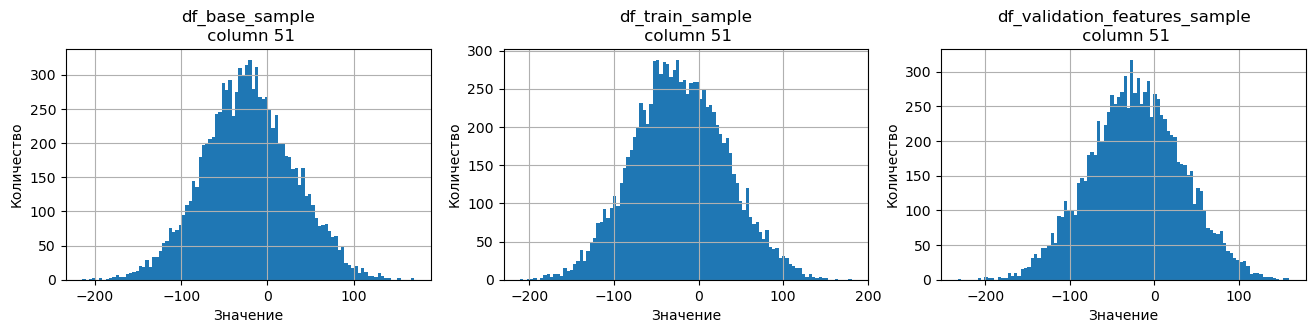

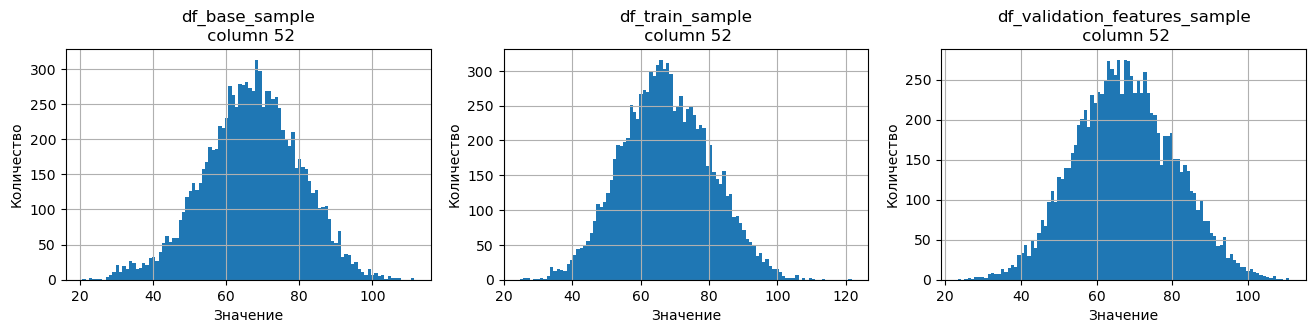

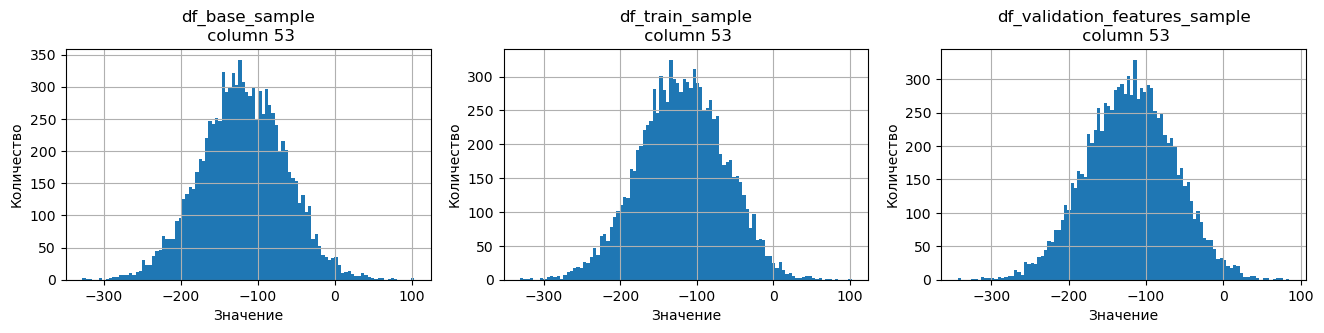

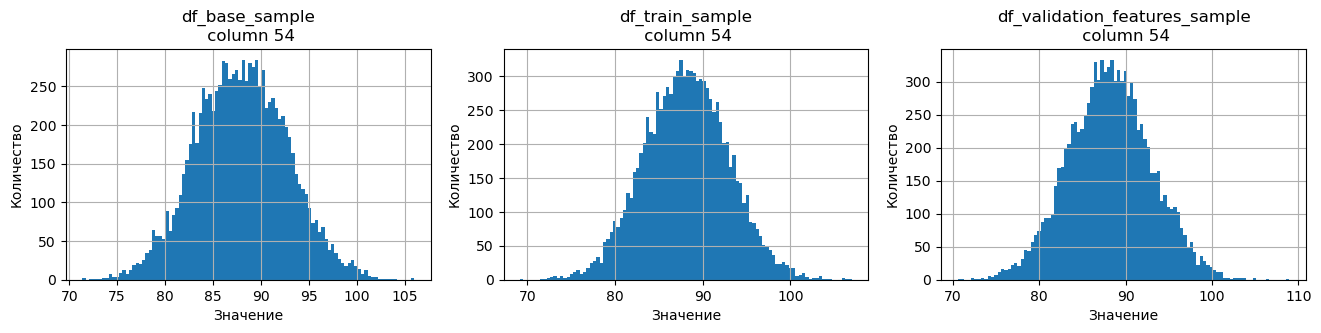

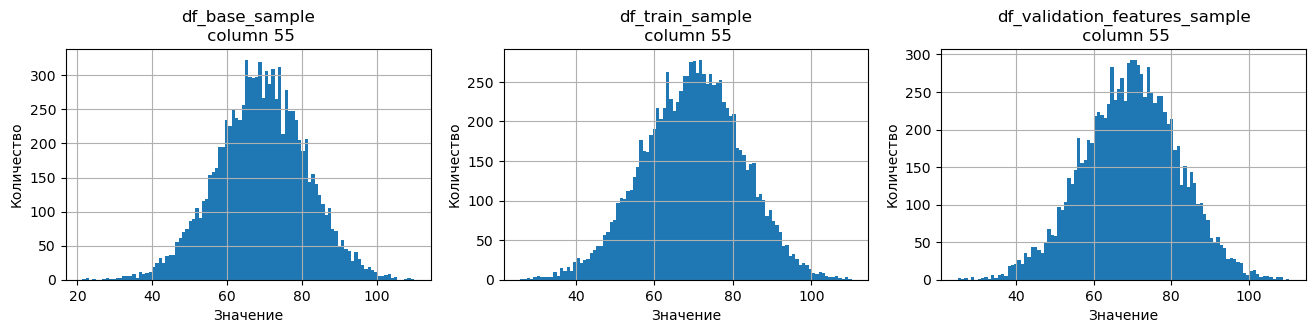

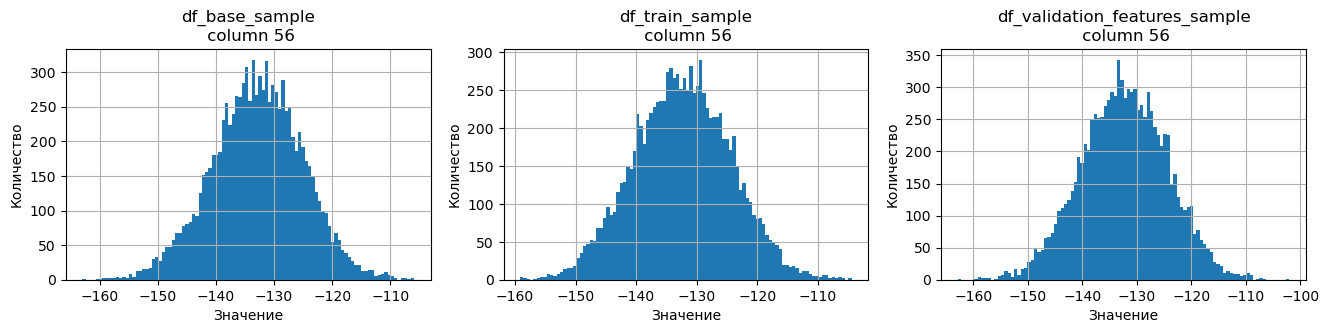

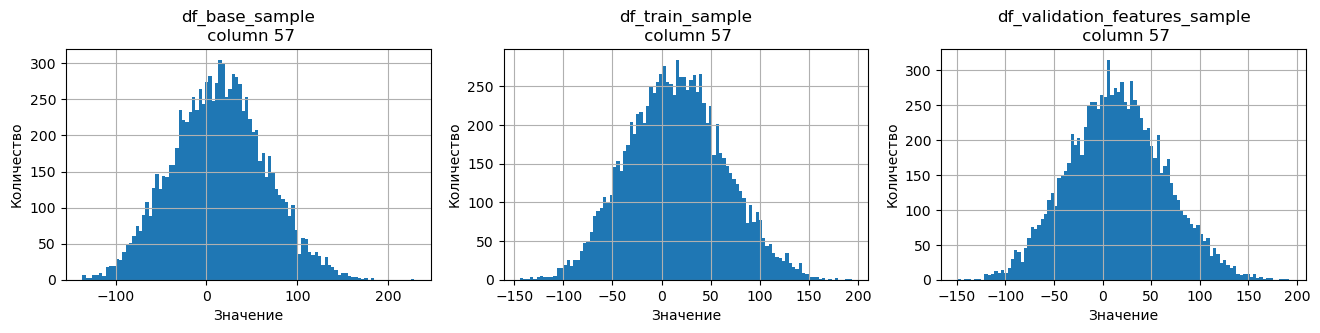

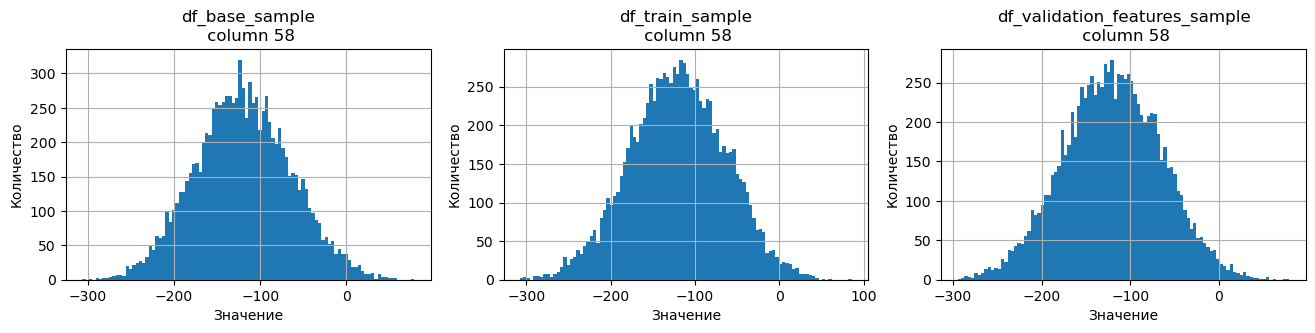

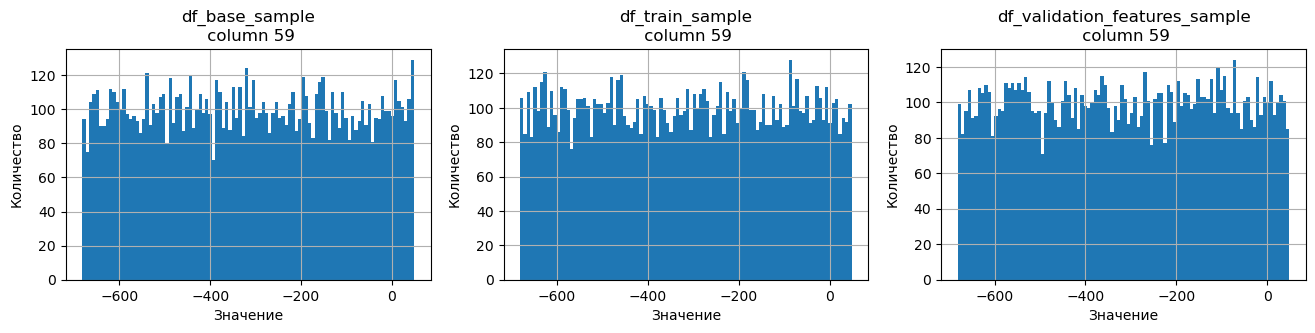

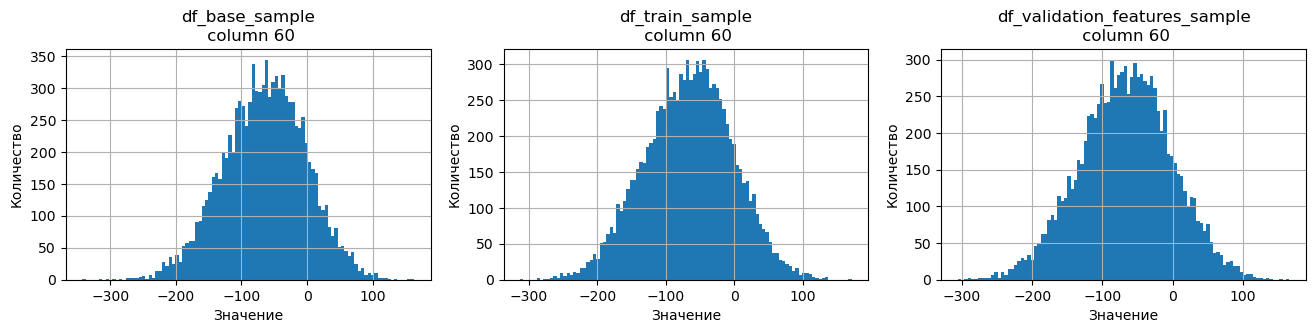

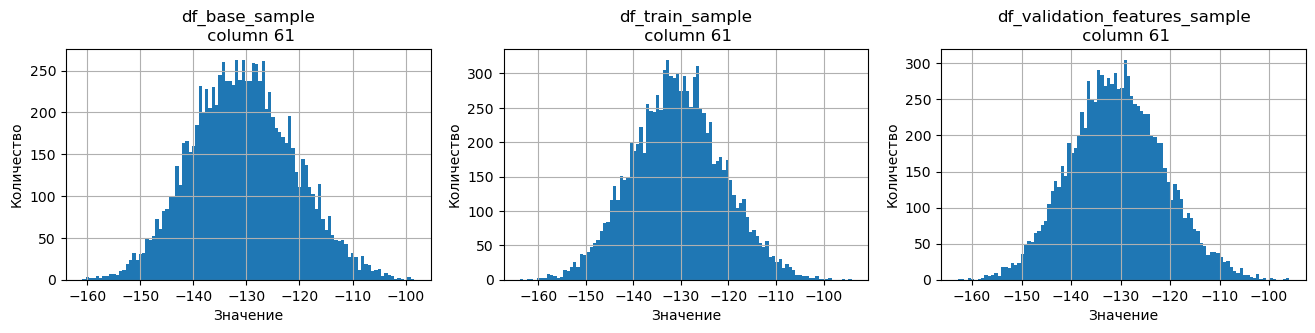

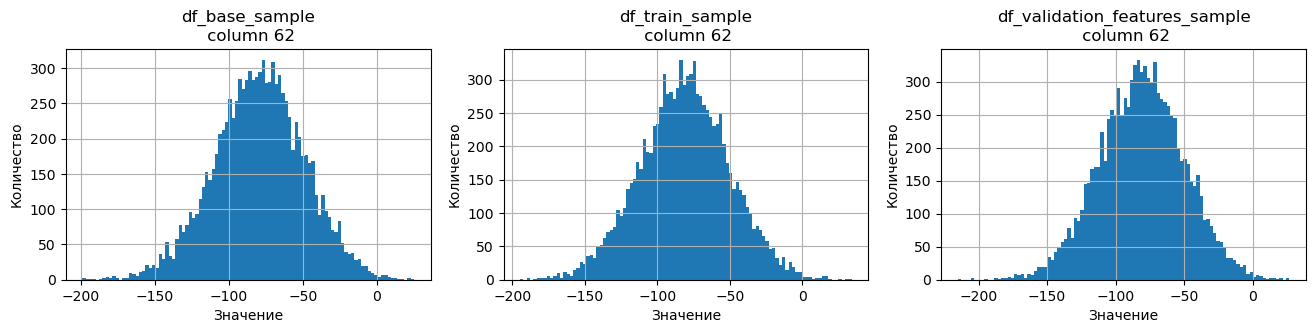

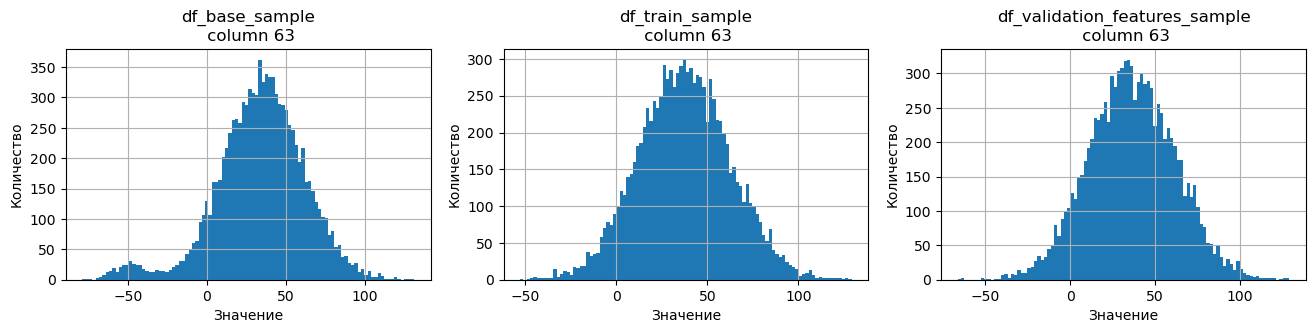

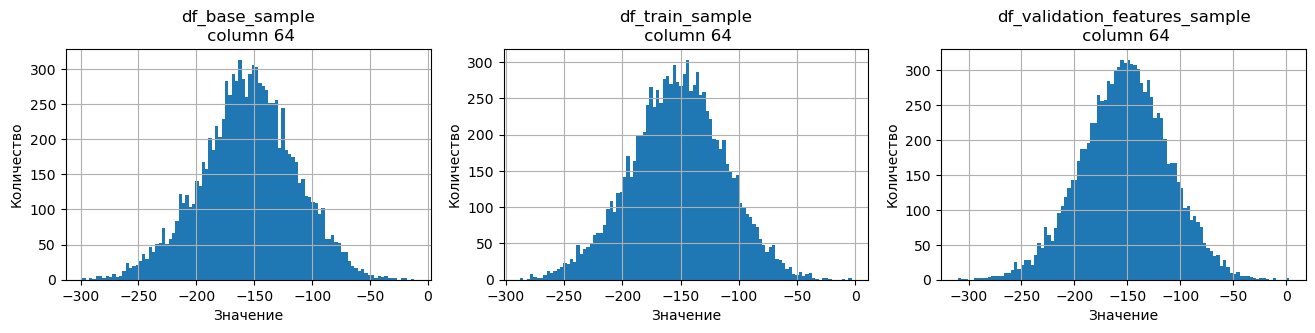

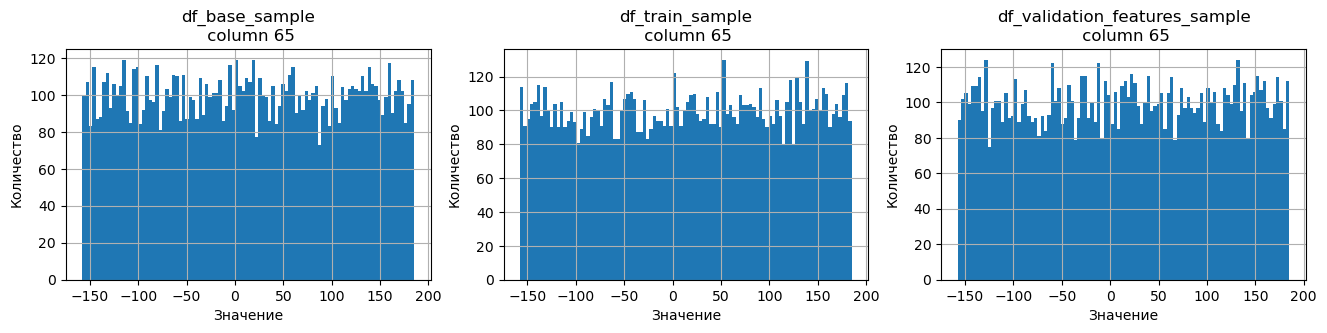

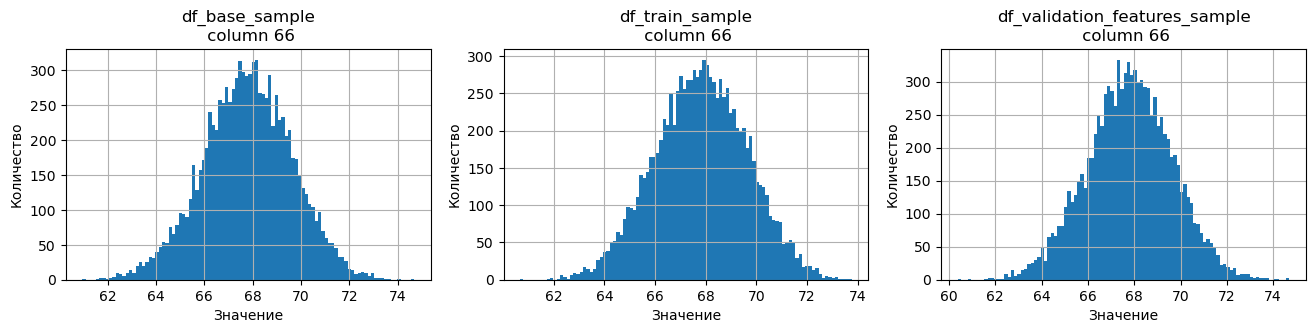

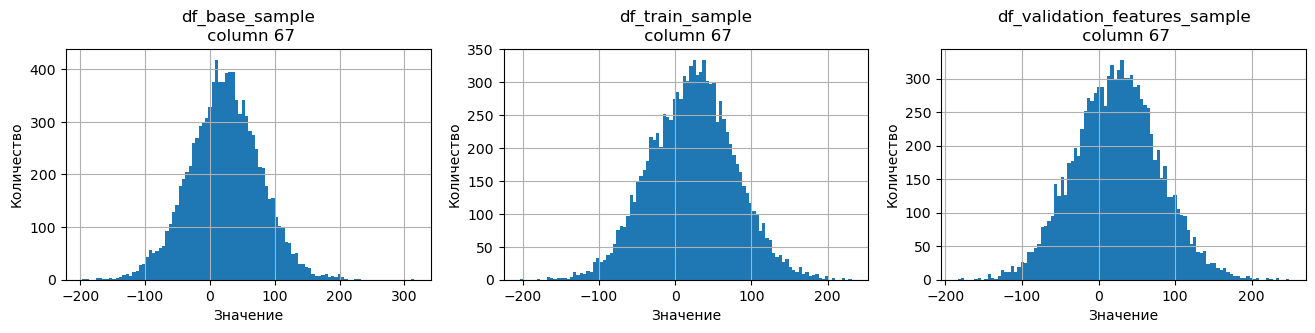

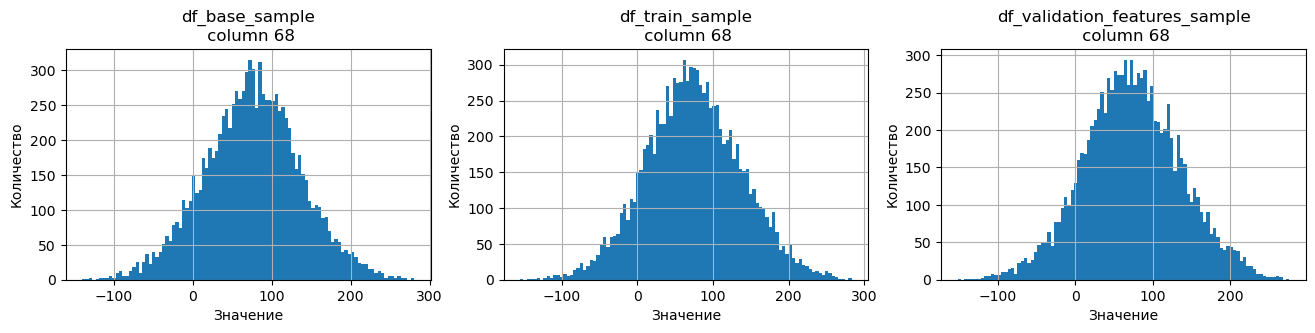

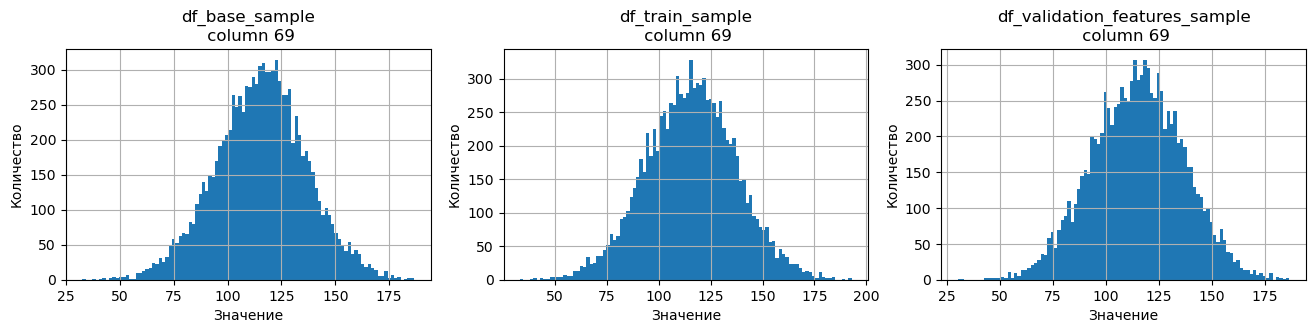

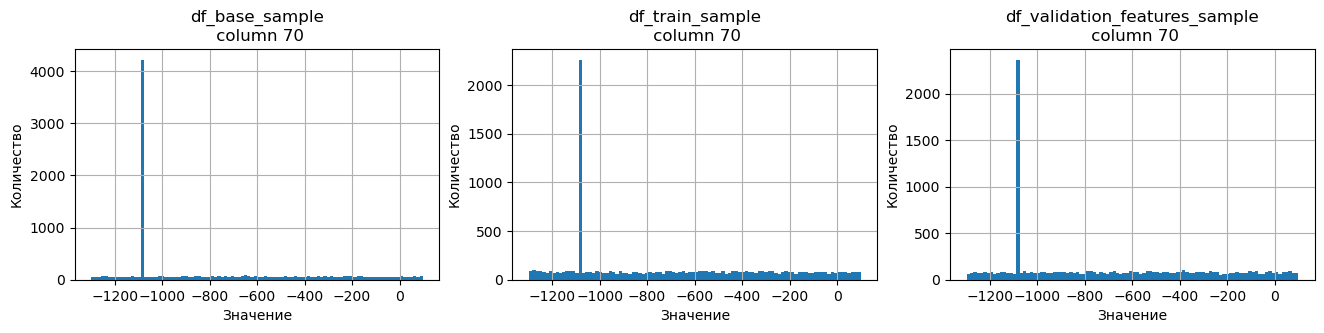

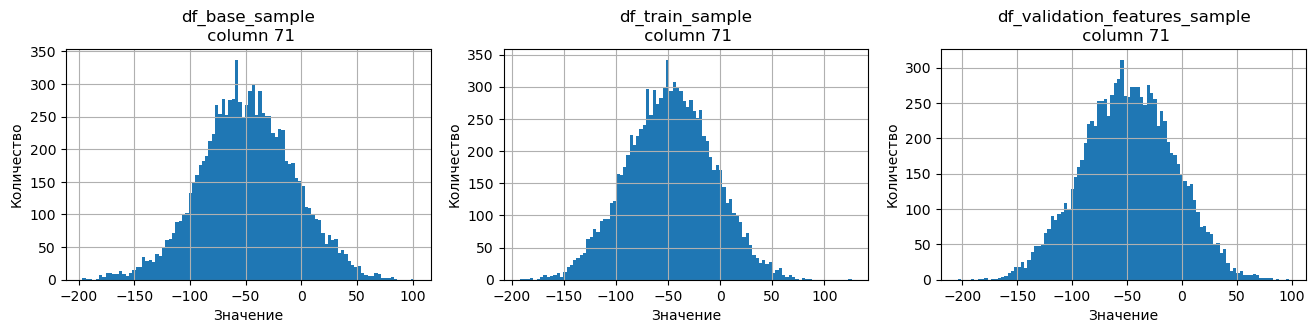

In [14]:
for i in df_base_sample.columns[1:73]:
    fig, axs = plt.subplots(1, 3, figsize=(16, 3))
    axs[0].hist(df_base_sample[i], bins=100)
    axs[0].set_title(f'df_base_sample\n column {i}')
    axs[0].set_xlabel('Значение')
    axs[0].set_ylabel('Количество')
    axs[0].grid(True)
    axs[1].hist(df_train_sample[i], bins=100)
    axs[1].set_title(f'df_train_sample\n column {i}')
    axs[1].set_xlabel('Значение')
    axs[1].set_ylabel('Количество')
    axs[1].grid(True)
    axs[2].hist(df_validation_features_sample[i], bins=100)
    axs[2].set_title(f'df_validation_features_sample\n column {i}')
    axs[2].set_xlabel('Значение')
    axs[2].set_ylabel('Количество')
    axs[2].grid(True)
    plt.show()

На основе полученных гистаграмм можно выделить следующие группы столбцов, влияние которых на результат требуется оценить дополнительно:
1. Столбцы 6, 33 и 70 - распределения данных в них не являются нормальными, данные распределены не равномерно и отличаются для датафреймов;
2. Столбцы 21, 25 и 44 -  распределения данных в них не вляются нормальными, данные распределены не равномерно и схожи для датафреймов;
3. Столбцы 59 и 65 -  распределения данных в них не вляются нормальными, данные распределены равномерно и схожи для датафреймов.


***Выводы***

По результатам анализа данных установлено:
1. Размерность датафреймов велика, поэтому решение данной задачи будем выполнять с помощью инструмента FAISS;
2. Пропуски в датафреймах отсутствуют;
3. Среди всех обучающих признаков выделены следующие группы столбцов, влияние которых на результат потребуется оценить дополнительно:
    1. Столбцы 6, 33 и 70 - распределения данных в них не являются нормальными, данные распределены не равномерно и отличаются для датафреймов;
    2. Столбцы 21, 25 и 44 -  распределения данных в них не вляются нормальными, данные распределены не равномерно и схожи для датафреймов;
    3. Столбцы 59 и 65 -  распределения данных в них не вляются нормальными, данные распределены равномерно и схожи для датафреймов.


## Подготовка данных

Подготовку данных будем выполнять путём масштабирования обучающих признаков. Данную процедуру будем выполнять на этапе подбора оптимальной комбинации обучающих признаков, так как это влияет на результат масштабирования. На данном этапе мы только создадим списки колонок, которые в дальнейшем будем оценивать.

In [15]:
df_base.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [16]:
main_cols = ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24',
       '26', '27', '28', '29', '30', '31', '32', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60',
       '61', '62', '63', '64', '66', '67', '68', '69', '71']

In [17]:
combinations_cols = [[],
                    ['59', '65'],
                    ['21', '25', '44'],
                    ['21', '25', '44', '59', '65'],
                    ['6', '33', '70'],
                    ['6', '33', '70', '59', '65'],
                    ['6', '33', '70', '21', '25', '44'],
                    ['6', '33', '70', '21', '25', '44', '59', '65']]

In [18]:
for sublist in combinations_cols:
    sublist.extend(main_cols)

## Создание алгоритма подбора ближайших соседей

Создание алгоритма будем выполнять с помощью инструмента FAISS в два этапа. На первом этапе будем определять количество соседних подвыборок, которые необходимо учитывать при поиске ближайших соседей, а на втором этапе выполним оценку работы модели поиска при различных комбинациях входных признаков.

### Подбор параметров для поиска соседей

Перед началом выполнения подбора параметров создадим датафрейм *pt_params*, в который будем записывать результаты поиска, а именно:
1. В столбец *nprobe* будем записывать количество ближайших подвыборок, которое будет использоваться для поиска ближайших соседей;
2. В столбец *time_train* будем записывать время, затраченное на обучение;
3. В столбец *accuracy* будем записывать полученный показатель качества *accuracy@5*.

In [19]:
pt_params = pd.DataFrame(columns = ['nprobe','time_search', 'accuracy'])

Определим параметры обучения и поиска FAISS. Количество выборок, на которае будет делиться датафрейм "df_base" определим как квадратный корень из количества строк в базе товаров.

In [20]:
dims = df_base.shape[1]
quantizer = faiss.IndexFlatIP(dims)
n_cells = round((df_base.shape[0])**0.5)

Дополнительно, для определения показателя качества *accuracy@5* создадим список *base_index* c Id товаров из базового датафрейма *df_base*.

In [21]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Выполним расчёт показателей *accuracy@5* при различных значениях *n_probe*.

In [22]:
%%time
i=0

idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

for n_probe in list(range(n_cells//32,n_cells//4,n_cells//64)):
    start = time.time()
    idx_l2.nprobe = n_probe 
    r, idx = idx_l2.search(np.ascontiguousarray(df_train_features.values).astype('float32'), 5)
    end  = time.time()
    time_search = end - start   
    
    acc = 0
    for target, el in zip(df_train_targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    acc = 100 * acc / len(idx)
        
    pt_params.loc[i] = np.array([n_probe, time_search, acc])
    i=i+1

Wall time: 6h 9min 11s


Выведем на экран полученные данные в табличном виде.

In [23]:
pt_params

,nprobe,time_search,accuracy
0,53.0,1451.345234,13.726
1,79.0,1438.023928,13.722
2,105.0,1439.374081,13.727
3,131.0,1468.452214,13.727
4,157.0,1496.374906,13.730
5,183.0,1450.186303,13.730
6,209.0,1480.326057,13.731
7,235.0,1497.977273,13.731
8,261.0,1493.406551,13.734
9,287.0,1489.662534,13.734


На основе полученных данных получаем, что наиболее рационалное значение *n_probe* составляет 391, так как выше данного значения увеличение метрики *accuracy@5* маловероятно, а время, затрачиваемое на поиск товаров, значительно возрастёт.

### Подбор обучающих признаков

Для выполнения анализа влияния различного сочетания обучающих признаков на результаты работы алгоритма создадим сводный датафрейм *pt_features*, в который будем записывать результаты, а именно:
* столбец *index_combin_cols*, в который будем записывать индекс из списка списков колонок *combinations_cols*;
* столбец *accuracy*, в который будем записывать полученное значение *accuracy@5* для исследуемой комбинации списков.

In [24]:
pt_features = pd.DataFrame(columns = ['index_combin_cols', 'accuracy'])

Выполним подбор ближайших соседей и определение значения *accuracy@5* для различных сочетаний входных признаков.

In [25]:
%%time
i=0
n_probe = 391
for cols in combinations_cols:
    df_base_prob = df_base[cols].copy()
    df_train_features_prob = df_train_features[cols].copy()
       
    scaler = StandardScaler()
    scaler.fit(df_base_prob)
    
    df_base_prob = scaler.transform(df_base_prob).copy()
    df_train_features_prob = scaler.transform(df_train_features_prob).copy()
   
    dims = df_base_prob.shape[1]
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    idx_l2.train(np.ascontiguousarray(df_base_prob).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base_prob).astype('float32'))
    
    idx_l2.nprobe = n_probe 
    r, idx = idx_l2.search(np.ascontiguousarray(df_train_features_prob).astype('float32'), 5)
    
    acc = 0
    for target, el in zip(df_train_targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    acc = 100 * acc / len(idx)
    
    pt_features.loc[i] = np.array([i, acc])
    i=i+1

Wall time: 1h 16min 32s


Выведем полученные результаты на экран.

In [26]:
pt_features

,index_combin_cols,accuracy
0,0.0,70.951
1,1.0,68.776
2,2.0,68.568
3,3.0,66.654
4,4.0,69.377
5,5.0,67.816
6,6.0,67.148
7,7.0,65.746


Наилучшее значение показателя качества *accuracy@5* составило 70.951 %. Стоит отметить, что данное значение получено при удалении из обучающих признаков всех колонок, не имеющих нормального распределения. Таким образом, запишем наилучшие полученные параметры при которых было получено наибольшее значение показателя качества *accuracy@5* (список столбцов *best_features* и параметры модели *best_n_cells* и *best_n_probe*).

In [27]:
best_features = combinations_cols[0]
best_n_cells = 1708
best_n_probe = 391

Далее, выполним финальные работы по обработке датафреймов и оценке показателя качества *accuracy@5*. Для этого создадим копии датафреймов с необходимыми столбцами обучающих признаков.

In [28]:
df_base_final = df_base[best_features].copy()
df_train_features_final = df_train_features[best_features].copy()
df_validation_features_final = df_validation_features[best_features].copy()

Выполним масштабирование признаков.

In [29]:
scaler = StandardScaler()
scaler.fit(df_base_final)
    
df_base_final = scaler.transform(df_base_final).copy()
df_train_features_final = scaler.transform(df_train_features_final).copy()
df_validation_features_final = scaler.transform(df_validation_features_final).copy()

Создадим модель и обучим её.

In [30]:
    dims = df_base_final.shape[1]
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, best_n_cells)
    
    idx_l2.train(np.ascontiguousarray(df_base_final).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base_final).astype('float32'))

Выполним поиск пяти ближайших соседей для тренировочного датафрейма *df_train_features_final* и определим показатель качества *accuracy@5*.

In [31]:
idx_l2.nprobe = best_n_probe 
r, idx = idx_l2.search(np.ascontiguousarray(df_train_features_final).astype('float32'), 5)

In [32]:
acc = 0
for target, el in zip(df_train_targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
acc = 100 * acc / len(idx)
acc

70.951

Полученное значение покзателя *accuracy@5* составило 70,951 %.

***Выводы***

1. Определены оптимальные значения параметров для применения инструмента FAISS;
2. Определён перечень обучающих признаков при использовании которых достигается наилучшее значение показателя качества *accuracy@5*;
3. С помощью инструмента FAISS разработан алгоритм (модель *idx_l2*) для поиска пяти ближайших "соседей", который на тренировочной выборке обеспечил показатель качества *accuracy@5* на уровне 70.951%.

## Проверка работы алгоритма на валидационных данных

Определим поиск пяти ближайших соседей для валидационных данных.

In [33]:
r, idx = idx_l2.search(np.ascontiguousarray(df_validation_features_final).astype('float32'), 5)

Выполним расчёт метрики *accuracy@5* для полученных значений.

In [34]:
acc = 0
for target, el in zip(df_validation_target['Expected'].values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

70.865


Значение показателя качества *accuracy@5*, полученное на валидационных данных, составило 70,865 %, что близко к значению, полученному на тренировочных данных.

## Общий вывод

1. По результатам выполненной работа разработама модель *idx_l2* позволяющая определять для нового товара пять наиболее близких по своим признаком товаров из базы.
2. Для модели *idx_l2* подобраны оптимальные параметры и определён список обучающих признаков, при которых достигается наилучшее значение метрики *accuracy@5*.
3. Показатель качества *accuracy@5* для тренировочных данных составил 70,951 %, для валидационных - 70,865 %.